In [1]:
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
%pylab inline

import pickle as pkl
from itertools import islice
import datetime
import random
import itertools
import glob
import pickle as pkl
import time
import os
import fancyimpute, impyute

from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input
from keras.optimizers import SGD
from keras.utils import plot_model

from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

rootPath = '../IMDA/'


Populating the interactive namespace from numpy and matplotlib


/Users/phuw273g/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


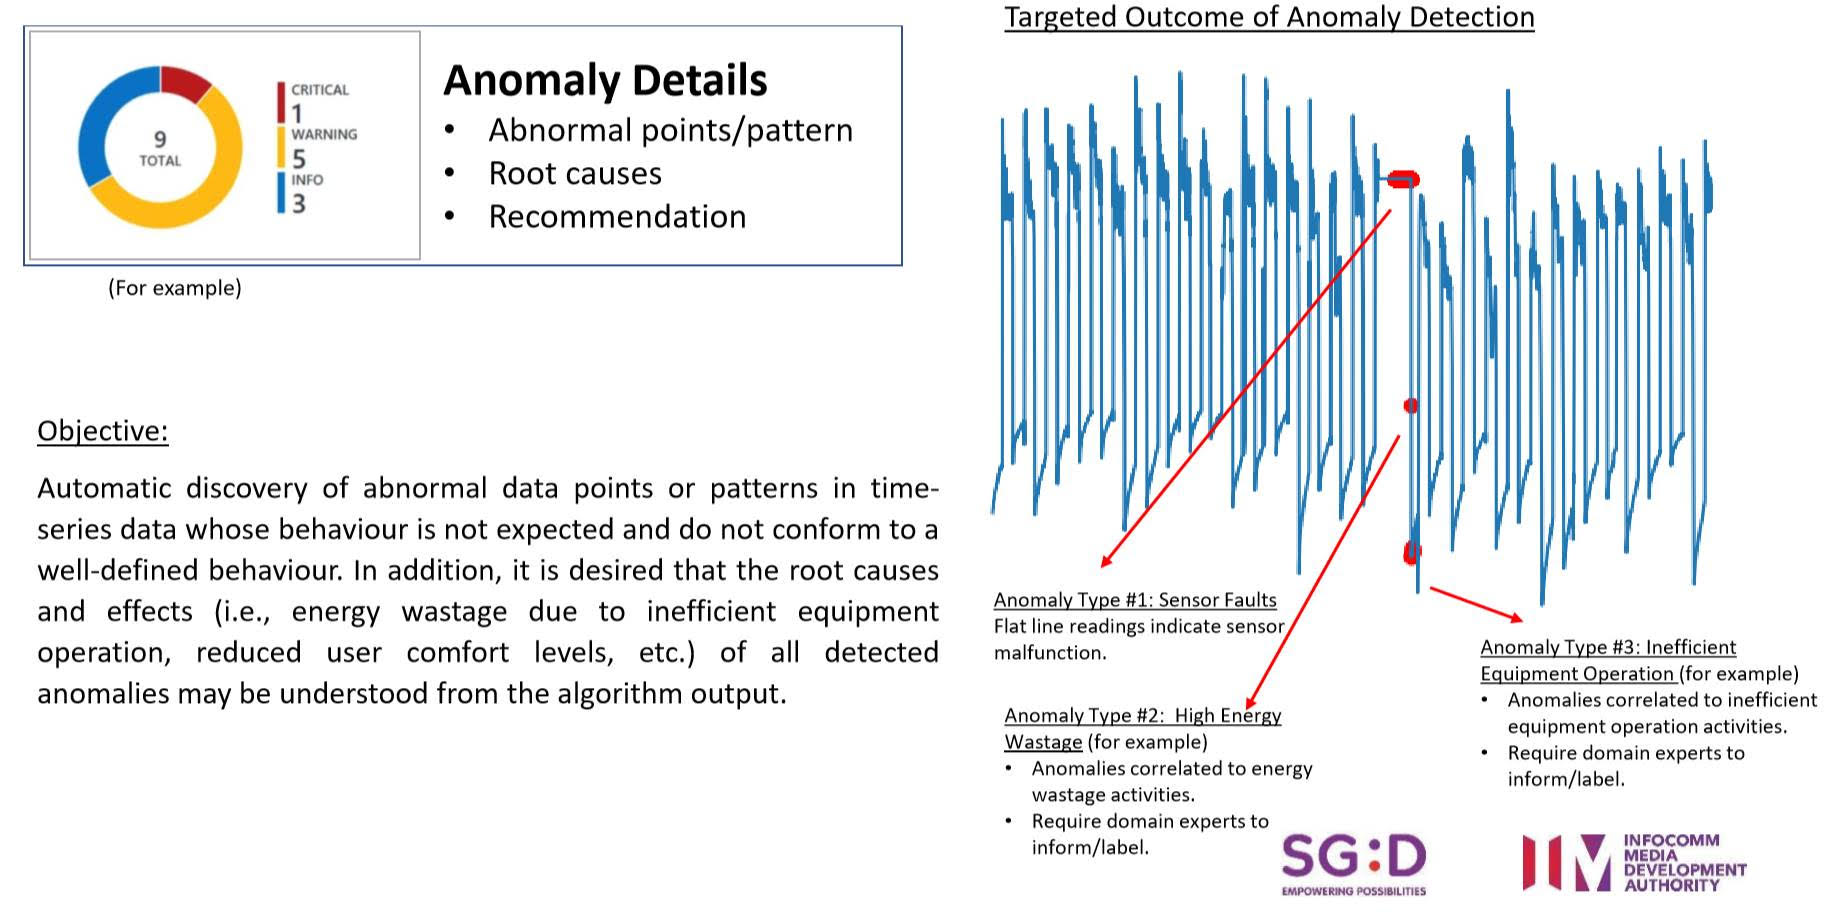

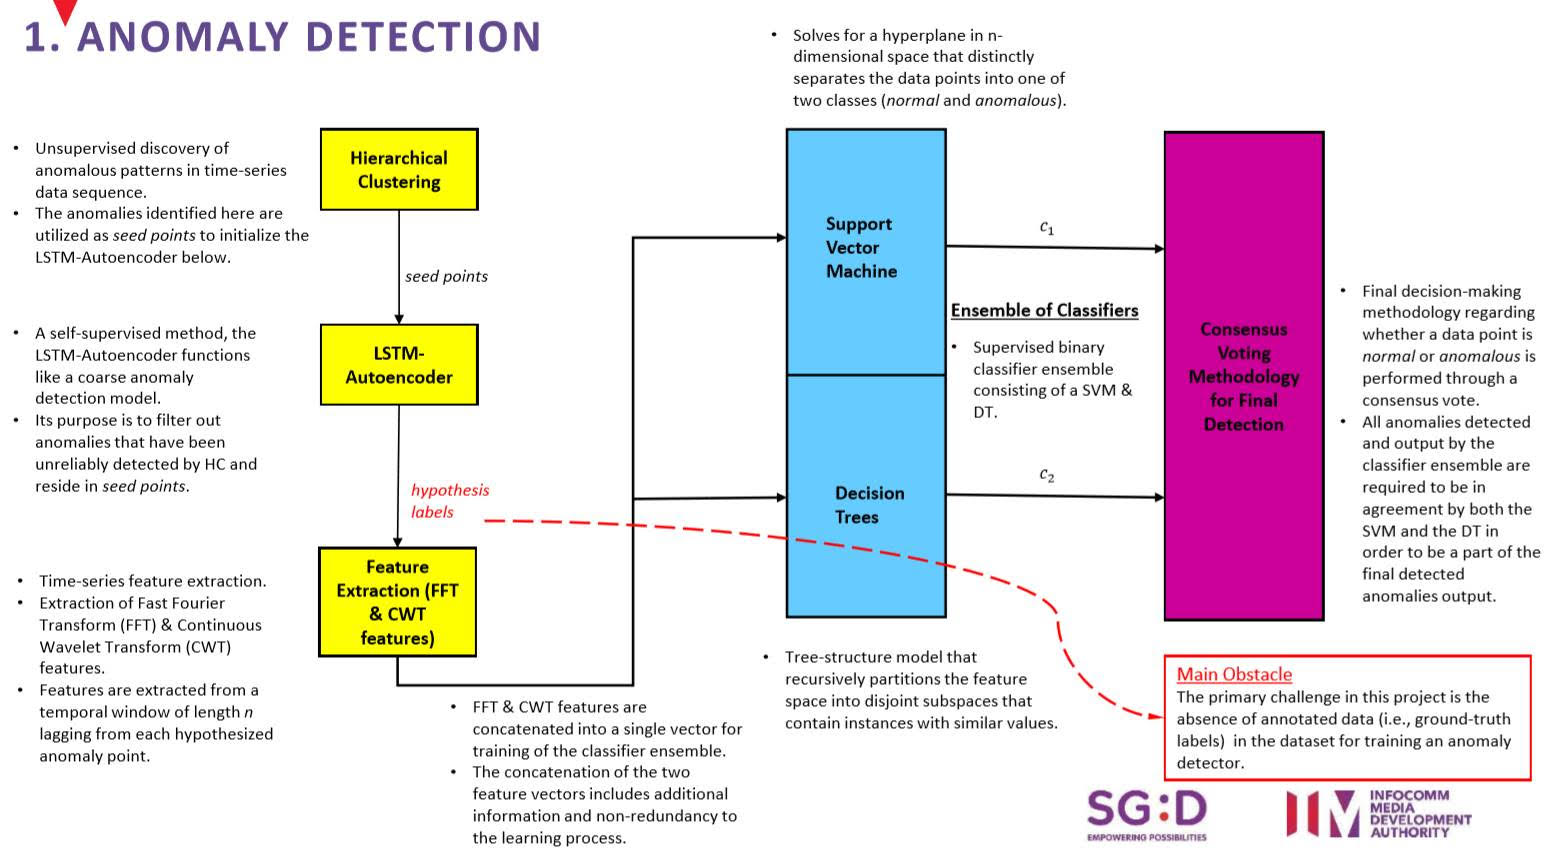

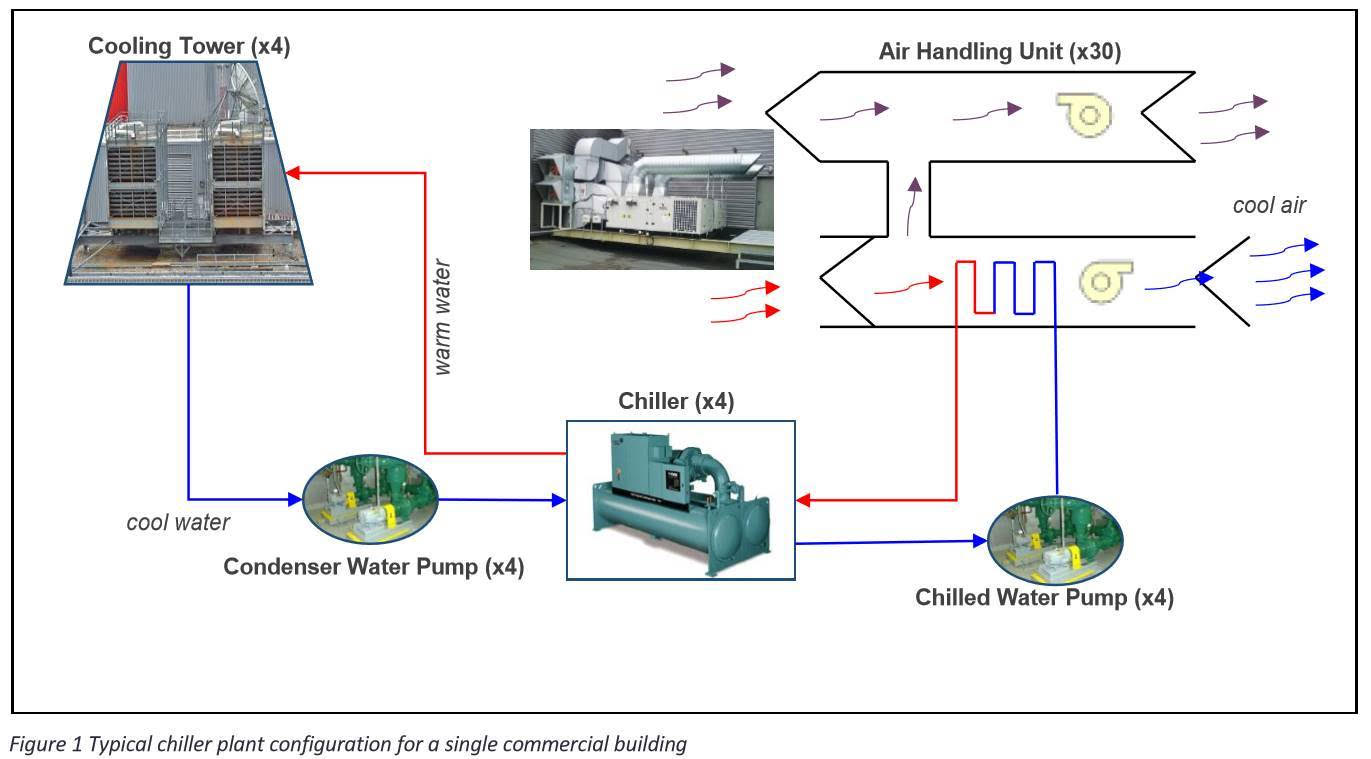
## Columns meaning:
 - CWRT: Condenser Water Return Temperature
 - HLI Entering CHW Temp: High Level Interface Entering (Return) Chilled Water Temperature

__*Anomaly Types*__ <br>
1. sensor fault
2. high energy wastage anomaly
3. inefficient equipment operation anomaly

In [2]:
def chopts(df_, cols, nts=int(24*60/5), overlapts=int(24*60/5)-1):
    # assume df_.index has no missing timestamps
    df = df_.copy()
    allts = list(df.index)
    allts.sort()
    ind = [j*(nts-overlapts) for j in range(int(len(allts)/(nts-overlapts)))]
    tsgrp = []
    for i in ind:
        tmp = allts[i: i+nts]
        if len(tmp) == nts:
            tsgrp.append(tmp)
    
    result = pd.DataFrame({'data': [df.loc[df.index.isin(tsgrp[i]), cols] for i in range(len(tsgrp))], 
                           'from': [tsgrp[i][0] for i in range(len(tsgrp))], 
                           'to': [tsgrp[i][-1] for i in range(len(tsgrp))]})
    return result


## Read Data

In [3]:
medianvalues_ts = pd.read_csv(rootPath+'medianvalues_ts.csv')
print(medianvalues_ts.shape)
print(medianvalues_ts.dtypes)
display(medianvalues_ts.head())

(2016, 4)
weekday                    int64
hourminute                 int64
CWRT_syth                float64
HLI Entering CHW Temp    float64
dtype: object


weekday  hourminute  CWRT_syth  HLI Entering CHW Temp
0        1           0  31.949000              12.400001
1        1           5  31.965000              12.400001
2        1          10  31.973000              12.400001
3        1          15  31.989001              12.500000
4        1          20  32.015001              12.525000

In [19]:
maincols = ['CWRT_syth', 'HLI Entering CHW Temp']
derivecol = ['(CWRT_syth)-(HLI Entering CHW Temp)']
timecols=['weekday', 'hourminute']
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

In [5]:
data_2 = pd.read_csv(rootPath+'data_2.csv', index_col='Unnamed: 0', date_parser=dateparse)
print(data_2.shape)
print(data_2.dtypes)
print(min(data_2.index), max(data_2.index))
display(data_2.head())


(17719, 13)
Date                                                object
Time                                                object
CWRT_syth                                          float64
HLI Entering CHW Temp                              float64
LABEL_(CWRT_syth)_(wrong_gap)                         bool
LABEL_(HLI Entering CHW Temp)_(wrong_gap)             bool
day                                                  int64
weekday                                              int64
hourminute                                           int64
LABEL_(CWRT_syth)_(extreme_value)                     bool
LABEL_(HLI Entering CHW Temp)_(extreme_value)         bool
LABEL_(CWRT_syth_profile)_(outlier)                   bool
LABEL_(HLI Entering CHW Temp_profile)_(outlier)       bool
dtype: object
2019-01-13 00:00:00 2019-03-15 12:30:00


Date   Time  CWRT_syth  HLI Entering CHW Temp  \
2019-01-13 00:00:00  2019-01-13  0000h  31.090000                    NaN   
2019-01-13 00:05:00  2019-01-13  0005h  31.106000                    NaN   
2019-01-13 00:10:00  2019-01-13  0010h  31.129999                   10.6   
2019-01-13 00:15:00  2019-01-13  0015h  31.146000                    NaN   
2019-01-13 00:20:00  2019-01-13  0020h  31.170000                    NaN   

                     LABEL_(CWRT_syth)_(wrong_gap)  \
2019-01-13 00:00:00                          False   
2019-01-13 00:05:00                          False   
2019-01-13 00:10:00                          False   
2019-01-13 00:15:00                          False   
2019-01-13 00:20:00                          False   

                     LABEL_(HLI Entering CHW Temp)_(wrong_gap)  day  weekday  \
2019-01-13 00:00:00                                      False   13        7   
2019-01-13 00:05:00                                      False   13        7   
2019-01-13 00:10:00                                      False   13        7   
2019-01-13 00:15:00                                      False   13        7   
2019-01-13 00:20:00                                      False   13        7   

                     hourminute  LABEL_(CWRT_syth)_(extreme_value)  \
2019-01-13 00:00:00           0                              False   
2019-01-13 00:05:00           5                              False   
2019-01-13 00:10:00          10                              False   
2019-01-13 00:15:00          15                              False   
2019-01-13 00:20:00          20                              False   

                     LABEL_(HLI Entering CHW Temp)_(extreme_value)  \
2019-01-13 00:00:00                                          False   
2019-01-13 00:05:00                                          False   
2019-01-13 00:10:00                                          False   
2019-01-13 00:15:00                                          False   
2019-01-13 00:20:00                                          False   

                     LABEL_(CWRT_syth_profile)_(outlier)  \
2019-01-13 00:00:00                                False   
2019-01-13 00:05:00                                False   
2019-01-13 00:10:00                                False   
2019-01-13 00:15:00                                False   
2019-01-13 00:20:00                                False   

                     LABEL_(HLI Entering CHW Temp_profile)_(outlier)  
2019-01-13 00:00:00                                            False  
2019-01-13 00:05:00                                            False  
2019-01-13 00:10:00                                            False  
2019-01-13 00:15:00                                            False  
2019-01-13 00:20:00                                            False

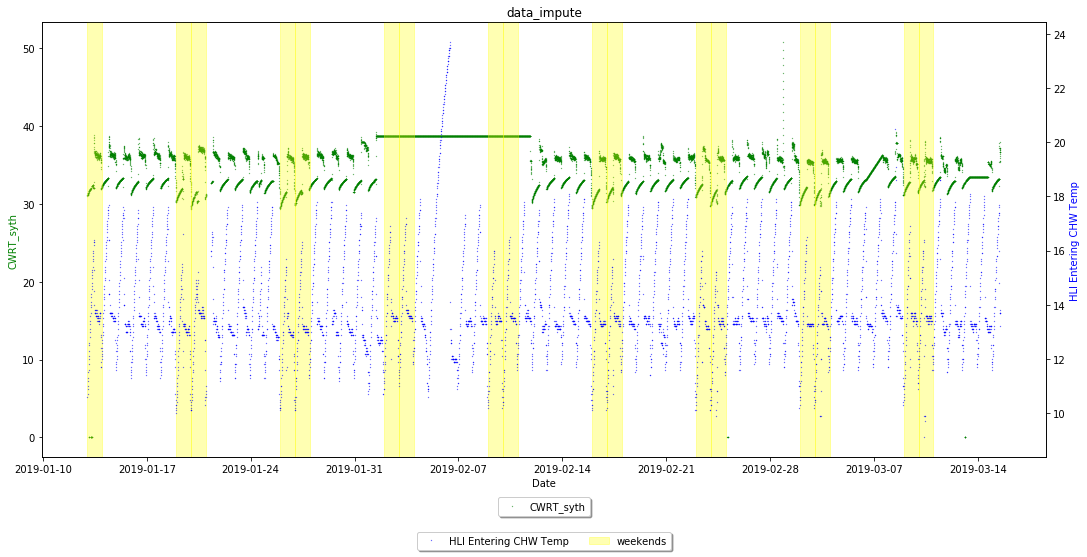

In [6]:
# plot
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

ax1.plot_date(data_2.index, data_2['CWRT_syth'], 
              c='g', markersize=0.5, marker='.', linewidth=1, linestyle='', label='CWRT_syth')
ax1.set_ylabel('CWRT_syth', color='g')
ax1.set_xlabel('Date')

ax2.plot_date(data_2.index, data_2['HLI Entering CHW Temp'], 
              c='b', markersize=0.5,  marker='.', linewidth=1, linestyle='', label='HLI Entering CHW Temp')
ax2.set_ylabel('HLI Entering CHW Temp', color='b')

tmp = data_2.index.to_frame()
tmp['wkday'] = data_2.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
    i += 1
       
plt.title('data_impute')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.show()


## Data Preparation

In [7]:
def findcorrectgap(pds, pctthreshold):
    gapcnt = pds['gap'].value_counts(ascending=False)
    if gapcnt.iloc[0] / gapcnt.sum() > pctthreshold:
        correct_gap = gapcnt.index[0]    
    else:
        correct_gap = None
    return correct_gap


def findheadandtailnanindex(df_, cols):
    df = df_.copy()
    result = {}
    for col in cols:
        pds = df[col].copy()
        head_ind = list(pds[:pds[pds.notnull()].index[0]].index[:-1])
        tail_ind = list(pds[pds[pds.notnull()].index[-1]:].index[1:])
        result[col] = head_ind + tail_ind
    return result
    
    
# ---------------------------- Imputation -----------------------------
# when the time gap is between (1, 3] times of normal gap, interpolate; 
# when the time gap is between (3, 5] times of normal gap, replace with median;
# else leave it empty

def imputets(df_, medianvalues_ts, correct_timegap, imputecols, timecols):
    df = df_.copy()
    mingap = min(correct_timegap.values())
    # get head and tail nan index
    headtailnanind = findheadandtailnanindex(df, maincols)
    
    for col in imputecols:
        pds = df[col].copy()
        
        tmp = pds.dropna().sort_index(ascending=True).to_frame()
        timediff = pd.Series(tmp.index) - pd.Series(tmp.index).shift()
        tmp['gap'] = pd.Series(list(timediff), index = tmp.index)
        tmp['periods_missed'] = tmp['gap']/mingap

        tmp = tmp[tmp['periods_missed']>1].copy()
        tmp['prev_dt'] = tmp.index.to_series() - tmp['gap'] + mingap

        tmp['dt_missed'] = None
        tmp.loc[tmp['prev_dt'].notna(), 'dt_missed'] = tmp[tmp['prev_dt'].notna()].apply(
                    lambda row: 
                    list(pd.date_range(str(row['prev_dt']), periods=int(row['periods_missed']-1), 
                                       freq=mingap)) 
                    if int(row['periods_missed']-1) > 0 else [row['prev_dt']], 
                    axis=1)

        tgap_morethan5 = tmp[tmp['gap']>5*correct_timegap[col]].copy()
        ts_leave = list(itertools.chain(*list(tgap_morethan5['dt_missed'])))
        df[col+'_leave_empty'] = False
        df.loc[df.index.isin(ts_leave), col+'_leave_empty']=True
        
        tgap_between3n5 = tmp[(tmp['gap']>3*correct_timegap[col]) & 
                              (tmp['gap']<=5*correct_timegap[col])].copy()
        ts_fillmedian = list(itertools.chain(*list(tgap_between3n5['dt_missed'])))
        df[col+'_fill_median'] = False
        df.loc[df.index.isin(ts_fillmedian+headtailnanind[col]), col+'_fill_median']=True

        # fill with median
        sub = df.loc[df[col+'_fill_median']==True, timecols].copy()
        df.loc[df[col+'_fill_median']==True, col] = sub.merge(medianvalues_ts[[col]+timecols], 
          on=timecols, how='left').set_index(sub.index)[col]
        
        # interpolate
        df.loc[:, col] = df.loc[:, col].interpolate(method='polynomial', order=1) 
        # leave blank
        df.loc[df[col+'_leave_empty']==True, col]=np.nan
    return df
  

In [8]:
# get correct time gaps
correct_timegap = {}
for col in maincols:
    tmp = data_2[col].sort_index(ascending=True).dropna().to_frame()
    timediff = pd.Series(tmp.index) - pd.Series(tmp.index).shift()
    tmp['gap'] = pd.Series(list(timediff), index = tmp.index)
    correct_timegap[col] = findcorrectgap(tmp, 0.7)

correct_timegap    


{'CWRT_syth': Timedelta('0 days 00:05:00'),
 'HLI Entering CHW Temp': Timedelta('0 days 00:15:00')}

In [9]:
# confirm no missing timestamp
pds = data_2.index.to_series()
pds2 = pds.reindex(pd.date_range(start=pds.index[0], end=pds.index[-1], freq=min(correct_timegap.values())))
print(len(np.unique(pds.index)), len(np.unique(pds2.index)))


17719 17719


In [10]:
# padding
windowsize = int(3*60/5)
startt = min(data_2.index)
endt = max(data_2.index)
tgap = min(correct_timegap.values())

dfhead = pd.DataFrame([], columns=list(data_2), index=[startt - tgap*i for i in range(1, windowsize)])
dfhead['weekday'] = dfhead.index.weekday+1
dfhead['hourminute'] = dfhead.index.hour*60+dfhead.index.minute
dftail = pd.DataFrame([], columns=list(data_2), index=[endt + tgap*i for i in range(1, windowsize)])
dftail['weekday'] = dftail.index.weekday+1
dftail['hourminute'] = dftail.index.hour*60+dfhead.index.minute

data_2_pad = dfhead.append(data_2).append(dftail).sort_index(ascending=True)

display(data_2_pad.head(50))
display(data_2_pad.tail(50))


Date   Time  CWRT_syth  HLI Entering CHW Temp  \
2019-01-12 21:05:00         NaN    NaN        NaN                    NaN   
2019-01-12 21:10:00         NaN    NaN        NaN                    NaN   
2019-01-12 21:15:00         NaN    NaN        NaN                    NaN   
2019-01-12 21:20:00         NaN    NaN        NaN                    NaN   
2019-01-12 21:25:00         NaN    NaN        NaN                    NaN   
2019-01-12 21:30:00         NaN    NaN        NaN                    NaN   
2019-01-12 21:35:00         NaN    NaN        NaN                    NaN   
2019-01-12 21:40:00         NaN    NaN        NaN                    NaN   
2019-01-12 21:45:00         NaN    NaN        NaN                    NaN   
2019-01-12 21:50:00         NaN    NaN        NaN                    NaN   
2019-01-12 21:55:00         NaN    NaN        NaN                    NaN   
2019-01-12 22:00:00         NaN    NaN        NaN                    NaN   
2019-01-12 22:05:00         NaN    NaN        NaN                    NaN   
2019-01-12 22:10:00         NaN    NaN        NaN                    NaN   
2019-01-12 22:15:00         NaN    NaN        NaN                    NaN   
2019-01-12 22:20:00         NaN    NaN        NaN                    NaN   
2019-01-12 22:25:00         NaN    NaN        NaN                    NaN   
2019-01-12 22:30:00         NaN    NaN        NaN                    NaN   
2019-01-12 22:35:00         NaN    NaN        NaN                    NaN   
2019-01-12 22:40:00         NaN    NaN        NaN                    NaN   
2019-01-12 22:45:00         NaN    NaN        NaN                    NaN   
2019-01-12 22:50:00         NaN    NaN        NaN                    NaN   
2019-01-12 22:55:00         NaN    NaN        NaN                    NaN   
2019-01-12 23:00:00         NaN    NaN        NaN                    NaN   
2019-01-12 23:05:00         NaN    NaN        NaN                    NaN   
2019-01-12 23:10:00         NaN    NaN        NaN                    NaN   
2019-01-12 23:15:00         NaN    NaN        NaN                    NaN   
2019-01-12 23:20:00         NaN    NaN        NaN                    NaN   
2019-01-12 23:25:00         NaN    NaN        NaN                    NaN   
2019-01-12 23:30:00         NaN    NaN        NaN                    NaN   
2019-01-12 23:35:00         NaN    NaN        NaN                    NaN   
2019-01-12 23:40:00         NaN    NaN        NaN                    NaN   
2019-01-12 23:45:00         NaN    NaN        NaN                    NaN   
2019-01-12 23:50:00         NaN    NaN        NaN                    NaN   
2019-01-12 23:55:00         NaN    NaN        NaN                    NaN   
2019-01-13 00:00:00  2019-01-13  0000h  31.090000                    NaN   
2019-01-13 00:05:00  2019-01-13  0005h  31.106000                    NaN   
2019-01-13 00:10:00  2019-01-13  0010h  31.129999              10.600000   
2019-01-13 00:15:00  2019-01-13  0015h  31.146000                    NaN   
2019-01-13 00:20:00  2019-01-13  0020h  31.170000                    NaN   
2019-01-13 00:25:00  2019-01-13  0025h  31.190000              10.700000   
2019-01-13 00:30:00  2019-01-13  0030h  31.219999                    NaN   
2019-01-13 00:35:00  2019-01-13  0035h  31.219999                    NaN   
2019-01-13 00:40:00  2019-01-13  0040h  31.236000              10.900001   
2019-01-13 00:45:00  2019-01-13  0045h  31.276000                    NaN   
2019-01-13 00:50:00  2019-01-13  0050h  31.299999                    NaN   
2019-01-13 00:55:00  2019-01-13  0055h  31.299999              11.000000   
2019-01-13 01:00:00  2019-01-13  0100h  31.316000                    NaN   
2019-01-13 01:05:00  2019-01-13  0105h  31.340000                    NaN   
2019-01-13 01:10:00  2019-01-13  0110h  31.360000              11.200000   

                    LABEL_(CWRT_syth)_(wrong_gap)  \
2019-01-12 21:05:00                           NaN   
2019-01-12 21:10:00                         

Date   Time  CWRT_syth  HLI Entering CHW Temp  \
2019-03-15 11:20:00  2019-03-15  1120h  36.668000                    NaN   
2019-03-15 11:25:00  2019-03-15  1125h  36.668000                    NaN   
2019-03-15 11:30:00  2019-03-15  1130h  36.678000                   13.7   
2019-03-15 11:35:00  2019-03-15  1135h  37.203999                    NaN   
2019-03-15 11:40:00  2019-03-15  1140h  37.236001                    NaN   
2019-03-15 11:45:00  2019-03-15  1145h  36.678000                   13.7   
2019-03-15 11:50:00  2019-03-15  1150h  37.024000                    NaN   
2019-03-15 11:55:00  2019-03-15  1155h  36.446000                    NaN   
2019-03-15 12:00:00  2019-03-15  1200h  36.119999                   13.7   
2019-03-15 12:05:00  2019-03-15  1205h  35.902001                    NaN   
2019-03-15 12:10:00  2019-03-15  1210h  35.434000                    NaN   
2019-03-15 12:15:00  2019-03-15  1215h  35.480000                   13.2   
2019-03-15 12:20:00  2019-03-15  1220h  35.570000                    NaN   
2019-03-15 12:25:00  2019-03-15  1225h        NaN                    NaN   
2019-03-15 12:30:00  2019-03-15  1230h        NaN                    NaN   
2019-03-15 12:35:00         NaN    NaN        NaN                    NaN   
2019-03-15 12:40:00         NaN    NaN        NaN                    NaN   
2019-03-15 12:45:00         NaN    NaN        NaN                    NaN   
2019-03-15 12:50:00         NaN    NaN        NaN                    NaN   
2019-03-15 12:55:00         NaN    NaN        NaN                    NaN   
2019-03-15 13:00:00         NaN    NaN        NaN                    NaN   
2019-03-15 13:05:00         NaN    NaN        NaN                    NaN   
2019-03-15 13:10:00         NaN    NaN        NaN                    NaN   
2019-03-15 13:15:00         NaN    NaN        NaN                    NaN   
2019-03-15 13:20:00         NaN    NaN        NaN                    NaN   
2019-03-15 13:25:00         NaN    NaN        NaN                    NaN   
2019-03-15 13:30:00         NaN    NaN        NaN                    NaN   
2019-03-15 13:35:00         NaN    NaN        NaN                    NaN   
2019-03-15 13:40:00         NaN    NaN        NaN                    NaN   
2019-03-15 13:45:00         NaN    NaN        NaN                    NaN   
2019-03-15 13:50:00         NaN    NaN        NaN                    NaN   
2019-03-15 13:55:00         NaN    NaN        NaN                    NaN   
2019-03-15 14:00:00         NaN    NaN        NaN                    NaN   
2019-03-15 14:05:00         NaN    NaN        NaN                    NaN   
2019-03-15 14:10:00         NaN    NaN        NaN                    NaN   
2019-03-15 14:15:00         NaN    NaN        NaN                    NaN   
2019-03-15 14:20:00         NaN    NaN        NaN                    NaN   
2019-03-15 14:25:00         NaN    NaN        NaN                    NaN   
2019-03-15 14:30:00         NaN    NaN        NaN                    NaN   
2019-03-15 14:35:00         NaN    NaN        NaN                    NaN   
2019-03-15 14:40:00         NaN    NaN        NaN                    NaN   
2019-03-15 14:45:00         NaN    NaN        NaN                    NaN   
2019-03-15 14:50:00         NaN    NaN        NaN                    NaN   
2019-03-15 14:55:00         NaN    NaN        NaN                    NaN   
2019-03-15 15:00:00         NaN    NaN        NaN                    NaN   
2019-03-15 15:05:00         NaN    NaN        NaN                    NaN   
2019-03-15 15:10:00         NaN    NaN        NaN                    NaN   
2019-03-15 15:15:00         NaN    NaN        NaN                    NaN   
2019-03-15 15:20:00         NaN    NaN        NaN                    NaN   
2019-03-15 15:25:00         NaN    NaN        NaN                    NaN   

                    LABEL_(CWRT_syth)_(wrong_gap)  \
2019-03-15 11:20:00                         False   
2019-03-15 11:25:00                         

In [12]:
data_2_impute = imputets(data_2_pad, medianvalues_ts, correct_timegap, maincols, timecols)

print(data_2_impute.shape)
print(data_2_impute.dtypes)
print(min(data_2_impute.index), max(data_2_impute.index))
display(data_2_impute.head())

(17789, 17)
Date                                                object
Time                                                object
CWRT_syth                                          float64
HLI Entering CHW Temp                              float64
LABEL_(CWRT_syth)_(wrong_gap)                       object
LABEL_(HLI Entering CHW Temp)_(wrong_gap)           object
day                                                 object
weekday                                              int64
hourminute                                           int64
LABEL_(CWRT_syth)_(extreme_value)                   object
LABEL_(HLI Entering CHW Temp)_(extreme_value)       object
LABEL_(CWRT_syth_profile)_(outlier)                 object
LABEL_(HLI Entering CHW Temp_profile)_(outlier)     object
CWRT_syth_leave_empty                                 bool
CWRT_syth_fill_median                                 bool
HLI Entering CHW Temp_leave_empty                     bool
HLI Entering CHW Temp_fill_median           

Date Time  CWRT_syth  HLI Entering CHW Temp  \
2019-01-12 21:05:00  NaN  NaN  35.456000              13.275000   
2019-01-12 21:10:00  NaN  NaN  35.466001              13.150000   
2019-01-12 21:15:00  NaN  NaN  35.484000              12.916667   
2019-01-12 21:20:00  NaN  NaN  35.303000              12.683334   
2019-01-12 21:25:00  NaN  NaN  35.160000              12.450000   

                    LABEL_(CWRT_syth)_(wrong_gap)  \
2019-01-12 21:05:00                           NaN   
2019-01-12 21:10:00                           NaN   
2019-01-12 21:15:00                           NaN   
2019-01-12 21:20:00                           NaN   
2019-01-12 21:25:00                           NaN   

                    LABEL_(HLI Entering CHW Temp)_(wrong_gap)  day  weekday  \
2019-01-12 21:05:00                                       NaN  NaN        6   
2019-01-12 21:10:00                                       NaN  NaN        6   
2019-01-12 21:15:00                                       NaN  NaN        6   
2019-01-12 21:20:00                                       NaN  NaN        6   
2019-01-12 21:25:00                                       NaN  NaN        6   

                     hourminute LABEL_(CWRT_syth)_(extreme_value)  \
2019-01-12 21:05:00        1265                               NaN   
2019-01-12 21:10:00        1270                               NaN   
2019-01-12 21:15:00        1275                               NaN   
2019-01-12 21:20:00        1280                               NaN   
2019-01-12 21:25:00        1285                               NaN   

                    LABEL_(HLI Entering CHW Temp)_(extreme_value)  \
2019-01-12 21:05:00                                           NaN   
2019-01-12 21:10:00                                           NaN   
2019-01-12 21:15:00                                           NaN   
2019-01-12 21:20:00                                           NaN   
2019-01-12 21:25:00                                           NaN   

                    LABEL_(CWRT_syth_profile)_(outlier)  \
2019-01-12 21:05:00                                 NaN   
2019-01-12 21:10:00                                 NaN   
2019-01-12 21:15:00                                 NaN   
2019-01-12 21:20:00                                 NaN   
2019-01-12 21:25:00                                 NaN   

                    LABEL_(HLI Entering CHW Temp_profile)_(outlier)  \
2019-01-12 21:05:00                                             NaN   
2019-01-12 21:10:00                                             NaN   
2019-01-12 21:15:00                                             NaN   
2019-01-12 21:20:00                                             NaN   
2019-01-12 21:25:00                                             NaN   

                     CWRT_syth_leave_empty  CWRT_syth_fill_median  \
2019-01-12 21:05:00                  False                   True   
2019-01-12 21:10:00                  False                   True   
2019-01-12 21:15:00                  False                   True   
2019-01-12 21:20:00                  False                   True   
2019-01-12 21:25:00                  False                   True   

                     HLI Entering CHW Temp_leave_empty  \
2019-01-12 21:05:00                              False   
2019-01-12 21:10:00                              False   
2019-01-12 21:15:00                              False   
2019-01-12 21:20:00                              False   
2019-01-12 21:25:00                              False   

                     HLI Entering CHW Temp_fill_median  
2019-01-12 21:05:00                               True  
2019-01-12 21:10:00                               True  
2019-01-12 21:15:00                               True  
2019-01-12 21:20:00                               True  
2019-01-12 21:25:00                               True

In [13]:
# add one more feature
data_2_impute['(CWRT_syth)-(HLI Entering CHW Temp)'] = data_2_impute['CWRT_syth']-data_2_impute[
    'HLI Entering CHW Temp']

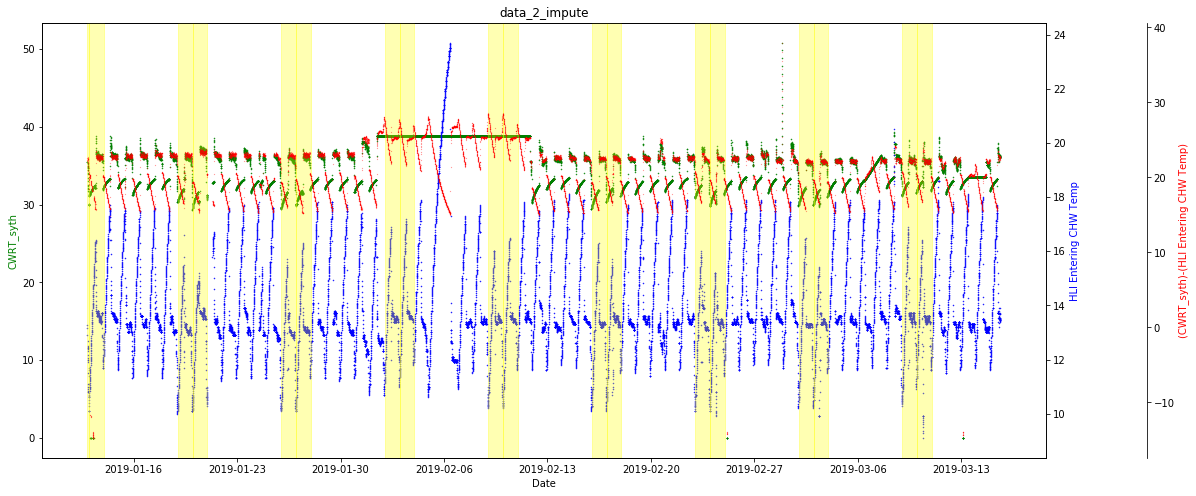

In [18]:
# plot
fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.1))


ax1.plot_date(data_2_impute.index, data_2_impute['CWRT_syth'], 
              c='g', markersize=1, marker='.', linewidth=1, linestyle='', 
              label='CWRT_syth')
ax1.set_ylabel('CWRT_syth', color='g')
ax1.set_xlabel('Date')

ax2.plot_date(data_2_impute.index, data_2_impute['HLI Entering CHW Temp'], 
              c='b', markersize=1,  marker='.', linewidth=1, linestyle='', 
              label='HLI Entering CHW Temp')
ax2.set_ylabel('HLI Entering CHW Temp', color='b')

ax3.plot_date(data_2_impute.index, data_2_impute['(CWRT_syth)-(HLI Entering CHW Temp)'], 
              c='r', markersize=0.3,  marker='.', linewidth=1, linestyle='', 
              label='(CWRT_syth)-(HLI Entering CHW Temp)')
ax3.set_ylabel('(CWRT_syth)-(HLI Entering CHW Temp)', color='r')

tmp = data_2_impute.index.to_frame()
tmp['wkday'] = data_2_impute.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
    i += 1
    
plt.title('data_2_impute')
# ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
# ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.show()


In [20]:
#------------------ min max scaling--------------------------
data_2_impute_scale = data_2_impute.copy()
scaler = MinMaxScaler()
scaler.fit(data_2_impute_scale[maincols+derivecol+timecols])
data_2_impute_scale[maincols+derivecol+timecols] = scaler.transform(
    data_2_impute_scale[maincols+derivecol+timecols])

print(data_2_impute_scale.shape)
display(data_2_impute_scale.head())

(17789, 18)


Date Time  CWRT_syth  HLI Entering CHW Temp  \
2019-01-12 21:05:00  NaN  NaN   0.697898               0.285959   
2019-01-12 21:10:00  NaN  NaN   0.698095               0.277397   
2019-01-12 21:15:00  NaN  NaN   0.698449               0.261416   
2019-01-12 21:20:00  NaN  NaN   0.694886               0.245434   
2019-01-12 21:25:00  NaN  NaN   0.692071               0.229452   

                    LABEL_(CWRT_syth)_(wrong_gap)  \
2019-01-12 21:05:00                           NaN   
2019-01-12 21:10:00                           NaN   
2019-01-12 21:15:00                           NaN   
2019-01-12 21:20:00                           NaN   
2019-01-12 21:25:00                           NaN   

                    LABEL_(HLI Entering CHW Temp)_(wrong_gap)  day   weekday  \
2019-01-12 21:05:00                                       NaN  NaN  0.833333   
2019-01-12 21:10:00                                       NaN  NaN  0.833333   
2019-01-12 21:15:00                                       NaN  NaN  0.833333   
2019-01-12 21:20:00                                       NaN  NaN  0.833333   
2019-01-12 21:25:00                                       NaN  NaN  0.833333   

                     hourminute LABEL_(CWRT_syth)_(extreme_value)  \
2019-01-12 21:05:00    0.881533                               NaN   
2019-01-12 21:10:00    0.885017                               NaN   
2019-01-12 21:15:00    0.888502                               NaN   
2019-01-12 21:20:00    0.891986                               NaN   
2019-01-12 21:25:00    0.895470                               NaN   

                    LABEL_(HLI Entering CHW Temp)_(extreme_value)  \
2019-01-12 21:05:00                                           NaN   
2019-01-12 21:10:00                                           NaN   
2019-01-12 21:15:00                                           NaN   
2019-01-12 21:20:00                                           NaN   
2019-01-12 21:25:00                                           NaN   

                    LABEL_(CWRT_syth_profile)_(outlier)  \
2019-01-12 21:05:00                                 NaN   
2019-01-12 21:10:00                                 NaN   
2019-01-12 21:15:00                                 NaN   
2019-01-12 21:20:00                                 NaN   
2019-01-12 21:25:00                                 NaN   

                    LABEL_(HLI Entering CHW Temp_profile)_(outlier)  \
2019-01-12 21:05:00                                             NaN   
2019-01-12 21:10:00                                             NaN   
2019-01-12 21:15:00                                             NaN   
2019-01-12 21:20:00                                             NaN   
2019-01-12 21:25:00                                             NaN   

                     CWRT_syth_leave_empty  CWRT_syth_fill_median  \
2019-01-12 21:05:00                  False                   True   
2019-01-12 21:10:00                  False                   True   
2019-01-12 21:15:00                  False                   True   
2019-01-12 21:20:00                  False                   True   
2019-01-12 21:25:00                  False                   True   

                     HLI Entering CHW Temp_leave_empty  \
2019-01-12 21:05:00                              False   
2019-01-12 21:10:00                              False   
2019-01-12 21:15:00                              False   
2019-01-12 21:20:00                              False   
2019-01-12 21:25:00                              False   

                     HLI Entering CHW Temp_fill_median  \
2019-01-12 21:05:00                               True   
2019-01-12 21:10:00                               True   
2019-01-12 21:15:00                               True   
2019-01-12 21:20:00                               True   
2019-01-12 21:25:00                               True   

                     (CWRT_syth)-(HLI Entering CHW Temp)  
2019-01-12 21:05:00              

In [23]:
#------------ sampling from sequence --------------------
number_ts = windowsize 

data_2_impute_scale_daily = chopts(
    data_2_impute_scale, maincols+derivecol+timecols, nts=number_ts, overlapts=number_ts-1)

data_2_impute_scale_daily['shape'] = data_2_impute_scale_daily['data'].apply(lambda x: x.shape)
for col in maincols+derivecol:
    data_2_impute_scale_daily[col+'_missing'] = data_2_impute_scale_daily[
        'data'].apply(lambda x: len(x[x[col].isna()]) / len(x))

print(min(data_2_impute_scale_daily['from']), max(data_2_impute_scale_daily['from']))
print(min(data_2_impute_scale_daily['to']), max(data_2_impute_scale_daily['to']))
print(data_2_impute_scale_daily.shape)
display(data_2_impute_scale_daily.describe())
display(data_2_impute_scale_daily.head())

2019-01-12 21:05:00 2019-03-15 12:30:00
2019-01-13 00:00:00 2019-03-15 15:25:00
(17754, 7)


CWRT_syth_missing  HLI Entering CHW Temp_missing  \
count       17754.000000                   17754.000000   
mean            0.005464                       0.005520   
std             0.068983                       0.069385   
min             0.000000                       0.000000   
25%             0.000000                       0.000000   
50%             0.000000                       0.000000   
75%             0.000000                       0.000000   
max             1.000000                       1.000000   

       (CWRT_syth)-(HLI Entering CHW Temp)_missing  
count                                 17754.000000  
mean                                      0.005520  
std                                       0.069385  
min                                       0.000000  
25%                                       0.000000  
50%                                       0.000000  
75%                                       0.000000  
max                                       1.000000

data                from  \
0                       CWRT_syth  HLI Entering C... 2019-01-12 21:05:00   
1                       CWRT_syth  HLI Entering C... 2019-01-12 21:10:00   
2                       CWRT_syth  HLI Entering C... 2019-01-12 21:15:00   
3                       CWRT_syth  HLI Entering C... 2019-01-12 21:20:00   
4                       CWRT_syth  HLI Entering C... 2019-01-12 21:25:00   

                   to    shape  CWRT_syth_missing  \
0 2019-01-13 00:00:00  (36, 5)                0.0   
1 2019-01-13 00:05:00  (36, 5)                0.0   
2 2019-01-13 00:10:00  (36, 5)                0.0   
3 2019-01-13 00:15:00  (36, 5)                0.0   
4 2019-01-13 00:20:00  (36, 5)                0.0   

   HLI Entering CHW Temp_missing  (CWRT_syth)-(HLI Entering CHW Temp)_missing  
0                            0.0                                          0.0  
1                            0.0                                          0.0  
2                            0.0                                          0.0  
3                            0.0                                          0.0  
4                            0.0                                          0.0

In [25]:
data_2_impute_scale_daily_nomissing = data_2_impute_scale_daily[
    data_2_impute_scale_daily[[c+'_missing' for c in maincols+derivecol]].sum(axis=1)==0].copy()

print(data_2_impute_scale_daily_nomissing.shape, 
      data_2_impute_scale_daily_nomissing.shape)
display(data_2_impute_scale_daily_nomissing.head())

(17621, 7) (17621, 7)


data                from  \
0                       CWRT_syth  HLI Entering C... 2019-01-12 21:05:00   
1                       CWRT_syth  HLI Entering C... 2019-01-12 21:10:00   
2                       CWRT_syth  HLI Entering C... 2019-01-12 21:15:00   
3                       CWRT_syth  HLI Entering C... 2019-01-12 21:20:00   
4                       CWRT_syth  HLI Entering C... 2019-01-12 21:25:00   

                   to    shape  CWRT_syth_missing  \
0 2019-01-13 00:00:00  (36, 5)                0.0   
1 2019-01-13 00:05:00  (36, 5)                0.0   
2 2019-01-13 00:10:00  (36, 5)                0.0   
3 2019-01-13 00:15:00  (36, 5)                0.0   
4 2019-01-13 00:20:00  (36, 5)                0.0   

   HLI Entering CHW Temp_missing  (CWRT_syth)-(HLI Entering CHW Temp)_missing  
0                            0.0                                          0.0  
1                            0.0                                          0.0  
2                            0.0                                          0.0  
3                            0.0                                          0.0  
4                            0.0                                          0.0

In [26]:
tmp = data_2_impute_scale_daily_nomissing.copy()
cond = tmp['shape']==tmp['shape'].value_counts(ascending=False).index[0]

data_x = {}

data_x['combine'] = np.stack(list(tmp.loc[cond, 'data'].apply(lambda x: x[maincols+timecols].values)))
print(data_x['combine'].shape)
display(data_x['combine'])

data_x['derive'] = np.stack(list(tmp.loc[cond, 'data'].apply(lambda x: x[derivecol+timecols].values)))
print(data_x['derive'].shape)
display(data_x['derive'])


(17621, 36, 4)


array([[[0.69789778, 0.28595889, 0.83333333, 0.8815331 ],
        [0.69809463, 0.27739723, 0.83333333, 0.88501742],
        [0.69844891, 0.2614155 , 0.83333333, 0.88850174],
        ...,
        [0.591292  , 0.13013699, 0.83333333, 0.99651568],
        [0.59144948, 0.08904111, 0.83333333, 1.        ],
        [0.61195967, 0.17808215, 1.        , 0.        ]],

       [[0.69809463, 0.27739723, 0.83333333, 0.88501742],
        [0.69844891, 0.2614155 , 0.83333333, 0.88850174],
        [0.6948862 , 0.24543377, 0.83333333, 0.89198606],
        ...,
        [0.59144948, 0.08904111, 0.83333333, 1.        ],
        [0.61195967, 0.17808215, 1.        , 0.        ],
        [0.6122746 , 0.13698627, 1.        , 0.00348432]],

       [[0.69844891, 0.2614155 , 0.83333333, 0.88850174],
        [0.6948862 , 0.24543377, 0.83333333, 0.89198606],
        [0.69207147, 0.22945204, 0.83333333, 0.89547038],
        ...,
        [0.61195967, 0.17808215, 1.        , 0.        ],
        [0.6122746 , 0.136986

(17621, 36, 3)


array([[[0.70059791, 0.83333333, 0.8815331 ],
        [0.70315778, 0.83333333, 0.88501742],
        [0.70792352, 0.83333333, 0.88850174],
        ...,
        [0.64103858, 0.83333333, 0.99651568],
        [0.65256742, 0.83333333, 1.        ],
        [0.64767526, 1.        , 0.        ]],

       [[0.70315778, 0.83333333, 0.88501742],
        [0.70792352, 0.83333333, 0.88850174],
        [0.70891586, 0.83333333, 0.89198606],
        ...,
        [0.65256742, 0.83333333, 1.        ],
        [0.64767526, 1.        , 0.        ],
        [0.65935578, 1.        , 0.00348432]],

       [[0.70792352, 0.83333333, 0.88850174],
        [0.70891586, 0.83333333, 0.89198606],
        [0.71062875, 0.83333333, 0.89547038],
        ...,
        [0.64767526, 1.        , 0.        ],
        [0.65935578, 1.        , 0.00348432],
        [0.6692918 , 1.        , 0.00696864]],

       ...,

       [[0.70133743, 0.66666667, 0.51567944],
        [0.71305588, 0.66666667, 0.51916376],
        [0.7075759 , 0

In [27]:
# check for nan
for k in data_x.keys():
    tmp = data_x[k]
    print(tmp[np.isnan(tmp)])

[]
[]


### __*predict all timestamps*__

In [58]:
def getpredict(model, dataarray):
    tmp = dataarray.reshape(1, dataarray.shape[0], dataarray.shape[1])
    return model.predict(tmp)


def calwindowperformance(dftrue_, dfpred, col, colnames=maincols):
    dftrue = dftrue_.copy()
    dfpred.columns = colnames
    absdiff = abs(dftrue_[col] - dfpred[col])
    return {'mae': absdiff.mean(), 'mse': (absdiff**2).mean(), 'rmse': (absdiff**2).mean()**0.5}
    
    

In [29]:
#model_3 = load_model('combine_autoencoder.h5')
model_3 = load_model('combine_timefeatures_autoencoder.h5')
model_4 = load_model('derive_timefeatures_autoencoder.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [30]:
data_2_impute_scale_daily_nomissing['pred_combine'] = data_2_impute_scale_daily_nomissing['data'].apply(
    lambda x: pd.DataFrame(getpredict(model_3, x[maincols+timecols].values)[0, :, :], 
                           columns=[maincols], index = x.index))
data_2_impute_scale_daily_nomissing['pred_derive'] = data_2_impute_scale_daily_nomissing['data'].apply(
    lambda x: pd.DataFrame(getpredict(model_4, x[derivecol+timecols].values)[0, :, :], 
                           columns=[derivecol], index = x.index))
print(data_2_impute_scale_daily_nomissing.shape)
display(data_2_impute_scale_daily_nomissing.head())

(17621, 9)


data                from  \
0                       CWRT_syth  HLI Entering C... 2019-01-12 21:05:00   
1                       CWRT_syth  HLI Entering C... 2019-01-12 21:10:00   
2                       CWRT_syth  HLI Entering C... 2019-01-12 21:15:00   
3                       CWRT_syth  HLI Entering C... 2019-01-12 21:20:00   
4                       CWRT_syth  HLI Entering C... 2019-01-12 21:25:00   

                   to    shape  CWRT_syth_missing  \
0 2019-01-13 00:00:00  (36, 5)                0.0   
1 2019-01-13 00:05:00  (36, 5)                0.0   
2 2019-01-13 00:10:00  (36, 5)                0.0   
3 2019-01-13 00:15:00  (36, 5)                0.0   
4 2019-01-13 00:20:00  (36, 5)                0.0   

   HLI Entering CHW Temp_missing  (CWRT_syth)-(HLI Entering CHW Temp)_missing  \
0                            0.0                                          0.0   
1                            0.0                                          0.0   
2                            0.0                                          0.0   
3                            0.0                                          0.0   
4                            0.0                                          0.0   

                                        pred_combine  \
0                      CWRT_syth HLI Entering CHW...   
1                      CWRT_syth HLI Entering CHW...   
2                      CWRT_syth HLI Entering CHW...   
3                      CWRT_syth HLI Entering CHW...   
4                      CWRT_syth HLI Entering CHW...   

                                         pred_derive  
0                      (CWRT_syth)-(HLI Entering ...  
1                      (CWRT_syth)-(HLI Entering ...  
2                      (CWRT_syth)-(HLI Entering ...  
3                      (CWRT_syth)-(HLI Entering ...  
4                      (CWRT_syth)-(HLI Entering ...

In [56]:
# allpredictions_1: get score statistics (mean, median, std, min, max) of all the predictions of each timestamp

allpredictions_1 = {}
for col in maincols:
    tmp = pd.concat(
        data_2_impute_scale_daily_nomissing['pred_combine'].apply(lambda x: x[col]).values, axis=1)
    tmp['mean'] = tmp.mean(axis=1)
    tmp['median'] = tmp.median(axis=1)
    tmp['std'] = tmp.std(axis=1)
    tmp['min'] = tmp.min(axis=1)
    tmp['max'] = tmp.max(axis=1)
    tmp['numpreds'] = tmp.count(axis=1)
    cols_ = ['mean', 'median', 'min', 'max', 'std', 'numpreds']
    tmp = tmp[cols_]
    tmp.columns = cols_
    allpredictions_1[col] = tmp.copy()
    print(allpredictions_1[col].shape)
    display(allpredictions_1[col].head())

col='(CWRT_syth)-(HLI Entering CHW Temp)'
tmp = pd.concat(data_2_impute_scale_daily_nomissing['pred_derive'].apply(lambda x: x[col]).values, axis=1)
tmp['mean'] = tmp.mean(axis=1)
tmp['median'] = tmp.median(axis=1)
tmp['std'] = tmp.std(axis=1)
tmp['min'] = tmp.min(axis=1)
tmp['max'] = tmp.max(axis=1)
tmp['numpreds'] = tmp.count(axis=1)
cols_ = ['mean', 'median', 'min', 'max', 'std', 'numpreds']
tmp = tmp[cols_]
tmp.columns = cols_
allpredictions_1[col] = tmp.copy()  
print(allpredictions_1[col].shape)
display(allpredictions_1[col].head())


(17691, 6)


mean    median       min       max       std  \
2019-01-12 21:05:00  0.657803  0.657803  0.000000  0.657803  0.000000   
2019-01-12 21:10:00  0.685079  0.685079  0.026026  0.716955  0.026026   
2019-01-12 21:15:00  0.692512  0.703049  0.028322  0.717000  0.028322   
2019-01-12 21:20:00  0.693608  0.707757  0.028834  0.714867  0.028834   
2019-01-12 21:25:00  0.691726  0.703750  0.028749  0.711527  0.028749   

                     numpreds  
2019-01-12 21:05:00         6  
2019-01-12 21:10:00         7  
2019-01-12 21:15:00         8  
2019-01-12 21:20:00         9  
2019-01-12 21:25:00        10

(17691, 6)


mean    median       min       max       std  \
2019-01-12 21:05:00  0.268005  0.268005  0.000000  0.268005  0.000000   
2019-01-12 21:10:00  0.241414  0.241414  0.017150  0.262419  0.017150   
2019-01-12 21:15:00  0.217547  0.213925  0.025571  0.256710  0.025571   
2019-01-12 21:20:00  0.197045  0.197045  0.030521  0.251188  0.030521   
2019-01-12 21:25:00  0.178935  0.170231  0.034103  0.246055  0.034103   

                     numpreds  
2019-01-12 21:05:00         6  
2019-01-12 21:10:00         7  
2019-01-12 21:15:00         8  
2019-01-12 21:20:00         9  
2019-01-12 21:25:00        10

(17691, 6)


mean    median       min       max       std  \
2019-01-12 21:05:00  0.711863  0.711863  0.000000  0.711863  0.000000   
2019-01-12 21:10:00  0.703831  0.703831  0.017576  0.725357  0.017576   
2019-01-12 21:15:00  0.701970  0.697673  0.021900  0.736207  0.021900   
2019-01-12 21:20:00  0.702860  0.702860  0.022842  0.744374  0.022842   
2019-01-12 21:25:00  0.704921  0.699056  0.022675  0.750974  0.022675   

                     numpreds  
2019-01-12 21:05:00         6  
2019-01-12 21:10:00         7  
2019-01-12 21:15:00         8  
2019-01-12 21:20:00         9  
2019-01-12 21:25:00        10

In [60]:
# allpredictions_2: assign window score (mae, mse, rmse) to the last timestamp of the window
allpredictions_2 = {}
for col in maincols:
    tmp = data_2_impute_scale_daily_nomissing[['data', 'pred_combine']].copy()
    tmp['performance'] = tmp.apply(
        lambda row: calwindowperformance(row['data'], row['pred_combine'], col, maincols), axis=1)
    tmp['timestamp'] = data_2_impute_scale_daily_nomissing['pred_combine'].apply(
        lambda x: x.index[-1])
    tmp.columns = ['data', 'pred_combine', 'performance', 'timestamp']
    allmtc = ['mae', 'mse', 'rmse']
    for mtc in allmtc:
        tmp[mtc] = tmp['performance'].apply(lambda x: x[mtc])
        mtc_min = tmp[mtc].min()
        mtc_max = tmp[mtc].max()
        tmp['normalized('+mtc+')'] = 100.0*(tmp[mtc]-mtc_min).div(mtc_max-mtc_min)
        
    allpredictions_2[col] = tmp[['timestamp']+allmtc+
                                ['normalized('+mtc+')' for mtc in allmtc]].copy().set_index('timestamp')
    print(allpredictions_2[col].shape)
    display(allpredictions_2[col].head())
    
    
col='(CWRT_syth)-(HLI Entering CHW Temp)'
tmp = data_2_impute_scale_daily_nomissing[['data', 'pred_derive']].copy()
tmp['performance'] = tmp.apply(
    lambda row: calwindowperformance(row['data'], row['pred_derive'], col, derivecol), axis=1)
tmp['timestamp'] = data_2_impute_scale_daily_nomissing['pred_derive'].apply(
    lambda x: x.index[-1])
tmp.columns = ['data', 'pred_derive', 'performance', 'timestamp']
allmtc = ['mae', 'mse', 'rmse']
for mtc in allmtc:
    tmp[mtc] = tmp['performance'].apply(lambda x: x[mtc])
    mtc_min = tmp[mtc].min()
    mtc_max = tmp[mtc].max()
    tmp['normalized('+mtc+')'] = 100.0*(tmp[mtc]-mtc_min).div(mtc_max-mtc_min)

allpredictions_2[col] = tmp[['timestamp']+allmtc+
                            ['normalized('+mtc+')' for mtc in allmtc]].copy().set_index('timestamp')
print(allpredictions_2[col].shape)
display(allpredictions_2[col].head())


(17621, 6)


mae       mse      rmse  normalized(mae)  \
timestamp                                                            
2019-01-13 00:00:00  0.051821  0.005383  0.073369         4.610714   
2019-01-13 00:05:00  0.047740  0.004375  0.066142         4.197883   
2019-01-13 00:10:00  0.042936  0.003405  0.058350         3.711933   
2019-01-13 00:15:00  0.037403  0.002544  0.050434         3.152226   
2019-01-13 00:20:00  0.032704  0.001847  0.042974         2.676847   

                     normalized(mse)  normalized(rmse)  
timestamp                                               
2019-01-13 00:00:00         0.441341          5.976443  
2019-01-13 00:05:00         0.357603          5.312796  
2019-01-13 00:10:00         0.277051          4.597387  
2019-01-13 00:15:00         0.205539          3.870550  
2019-01-13 00:20:00         0.147672          3.185597

(17621, 6)


mae       mse      rmse  normalized(mae)  \
timestamp                                                            
2019-01-13 00:00:00  0.058412  0.004430  0.066557         7.404164   
2019-01-13 00:05:00  0.063054  0.005145  0.071731         8.037183   
2019-01-13 00:10:00  0.066338  0.005863  0.076568         8.484913   
2019-01-13 00:15:00  0.067244  0.006171  0.078553         8.608534   
2019-01-13 00:20:00  0.067267  0.006227  0.078908         8.611691   

                     normalized(mse)  normalized(rmse)  
timestamp                                               
2019-01-13 00:00:00         0.761250          8.040552  
2019-01-13 00:05:00         0.885191          8.726856  
2019-01-13 00:10:00         1.009445          9.368456  
2019-01-13 00:15:00         1.062785          9.631767  
2019-01-13 00:20:00         1.072482          9.678927

(17621, 6)


mae       mse      rmse  normalized(mae)  \
timestamp                                                            
2019-01-13 00:00:00  0.023579  0.000819  0.028625         6.662025   
2019-01-13 00:05:00  0.021477  0.000597  0.024443         5.970448   
2019-01-13 00:10:00  0.020328  0.000558  0.023623         5.592321   
2019-01-13 00:15:00  0.019759  0.000552  0.023494         5.405158   
2019-01-13 00:20:00  0.019152  0.000523  0.022873         5.205409   

                     normalized(mse)  normalized(rmse)  
timestamp                                               
2019-01-13 00:00:00         0.554757          6.474512  
2019-01-13 00:05:00         0.401033          5.361342  
2019-01-13 00:10:00         0.373737          5.143119  
2019-01-13 00:15:00         0.369515          5.108684  
2019-01-13 00:20:00         0.349563          4.943323

In [69]:
data_2 = pd.read_csv(rootPath+'data_2.csv', index_col='Unnamed: 0', date_parser=dateparse)
print(data_2.shape)
print(len(set(data_2.index)), len(data_2))
print(min(data_2.index), max(data_2.index))


(17719, 13)
17719 17719
2019-01-13 00:00:00 2019-03-15 12:30:00


In [70]:
tmp = data_2_impute_scale.copy()

# allpredictions_1
for col in allpredictions_1.keys():
    tmp = pd.concat([tmp, allpredictions_1[col][['mean', 'median']].rename(
        columns={'mean': 'Pred_'+col+'_timestamp_mean', 
                 'median': 'Pred_'+col+'_timestamp_median'})], axis=1)

for col in allpredictions_1.keys():
    diff1 = abs(tmp['Pred_'+col+'_timestamp_mean']-tmp[col])
    diff_min1 = diff1.min()
    diff_max1 = diff1.max()
    tmp['Score_('+col+')_timstamp_normalized(mean)'] = 100*(diff1-diff_min1).div(diff_max1-diff_min1)
    
    diff2 = abs(tmp['Pred_'+col+'_timestamp_median']-tmp[col])
    diff_min2 = diff2.min()
    diff_max2 = diff2.max()
    tmp['Score_('+col+')_timstamp_normalized(median)'] = 100*(diff2-diff_min2).div(diff_max2-diff_min2) 

data_2 = data_2.merge(tmp[
    ['Score_('+col+')_timstamp_normalized(mean)' for col in allpredictions_1.keys()]+
    ['Score_('+col+')_timstamp_normalized(median)' for col in allpredictions_1.keys()]], how='left', left_on=data_2.index, 
                          right_on=tmp.index).set_index('key_0')
data_2.index.name = 'timestamp'

for col in maincols:
    data_2.loc[data_2[col].isna(), 'Score_('+col+')_timstamp_normalized(mean)'] = np.nan
    data_2.loc[data_2[col].isna(), 'Score_('+col+')_timstamp_normalized(median)'] = np.nan

col = '(CWRT_syth)-(HLI Entering CHW Temp)'
data_2.loc[data_2[maincols].isna().sum(axis=1)>0, 'Score_('+col+')_timstamp_normalized(mean)'] = np.nan
data_2.loc[data_2[maincols].isna().sum(axis=1)>0, 'Score_('+col+')_timstamp_normalized(median)'] = np.nan

display(data_2.head(50))  


Date   Time  CWRT_syth  HLI Entering CHW Temp  \
timestamp                                                                  
2019-01-13 00:00:00  2019-01-13  0000h  31.090000                    NaN   
2019-01-13 00:05:00  2019-01-13  0005h  31.106000                    NaN   
2019-01-13 00:10:00  2019-01-13  0010h  31.129999              10.600000   
2019-01-13 00:15:00  2019-01-13  0015h  31.146000                    NaN   
2019-01-13 00:20:00  2019-01-13  0020h  31.170000                    NaN   
2019-01-13 00:25:00  2019-01-13  0025h  31.190000              10.700000   
2019-01-13 00:30:00  2019-01-13  0030h  31.219999                    NaN   
2019-01-13 00:35:00  2019-01-13  0035h  31.219999                    NaN   
2019-01-13 00:40:00  2019-01-13  0040h  31.236000              10.900001   
2019-01-13 00:45:00  2019-01-13  0045h  31.276000                    NaN   
2019-01-13 00:50:00  2019-01-13  0050h  31.299999                    NaN   
2019-01-13 00:55:00  2019-01-13  0055h  31.299999              11.000000   
2019-01-13 01:00:00  2019-01-13  0100h  31.316000                    NaN   
2019-01-13 01:05:00  2019-01-13  0105h  31.340000                    NaN   
2019-01-13 01:10:00  2019-01-13  0110h  31.360000              11.200000   
2019-01-13 01:15:00  2019-01-13  0115h  31.389999                    NaN   
2019-01-13 01:20:00  2019-01-13  0120h  31.389999                    NaN   
2019-01-13 01:25:00  2019-01-13  0125h  31.406000              11.300000   
2019-01-13 01:30:00  2019-01-13  0130h  31.430000                    NaN   
2019-01-13 01:35:00  2019-01-13  0135h  31.446000                    NaN   
2019-01-13 01:40:00  2019-01-13  0140h  31.469999              11.500000   
2019-01-13 01:45:00  2019-01-13  0145h  31.469999                    NaN   
2019-01-13 01:50:00  2019-01-13  0150h  31.469999                    NaN   
2019-01-13 01:55:00  2019-01-13  0155h  31.490000              11.600000   
2019-01-13 02:00:00  2019-01-13  0200h   0.000000                    NaN   
2019-01-13 02:05:00  2019-01-13  0205h   0.000000                    NaN   
2019-01-13 02:10:00  2019-01-13  0210h   0.000000              11.800000   
2019-01-13 02:15:00  2019-01-13  0215h   0.000000                    NaN   
2019-01-13 02:20:00  2019-01-13  0220h   0.000000                    NaN   
2019-01-13 02:25:00  2019-01-13  0225h   0.000000              12.000000   
2019-01-13 02:30:00  2019-01-13  0230h  31.616000                    NaN   
2019-01-13 02:35:00  2019-01-13  0235h  31.639999                    NaN   
2019-01-13 02:40:00  2019-01-13  0240h  31.639999              12.100000   
2019-01-13 02:45:00  2019-01-13  0245h  31.639999                    NaN   
2019-01-13 02:50:00  2019-01-13  0250h  31.639999                    NaN   
2019-01-13 02:55:00  2019-01-13  0255h  31.660000              12.300000   
2019-01-13 03:00:00  2019-01-13  0300h  31.690001                    NaN   
2019-01-13 03:05:00  2019-01-13  0305h  31.706000                    NaN   
2019-01-13 03:10:00  2019-01-13  0310h  31.730000              12.500000   
2019-01-13 03:15:00  2019-01-13  0315h  31.730000                    NaN   
2019-01-13 03:20:00  2019-01-13  0320h  31.730000                    NaN   
2019-01-13 03:25:00  2019-01-13  0325h  31.746000              12.600000   
2019-01-13 03:30:00  2019-01-13  0330h  31.770000                    NaN   
2019-01-13 03:35:00  2019-01-13  0335h  31.770000                    NaN   
2019-01-13 03:40:00  2019-01-13  0340h  31.790000              12.800000   
2019-01-13 03:45:00  2019-01-13  0345h  31.820000                    NaN   
2019-01-13 03:50:00  2019-01-13  0350h  31.820000                    NaN   
2019-01-13 03:55:00  2019-01-13  0355h  31.820000              13.000000   
2019-01-13 04:00:00  2019-01-13  0400h  31.836000                    NaN   
2019-01-13 04:05:00  2019-01-13  0405h  31.860001                    NaN   

                     LABEL_(CWRT_syth)_(wrong_gap)  \
timestamp           

In [71]:
# allpredictions_2
for col in allpredictions_2.keys():
    data_2 = data_2.merge(allpredictions_2[col][
        ['normalized(mae)', 'normalized(mse)', 'normalized(rmse)']].rename(
        columns={'normalized(mae)': 'Score_('+col+')_window_normalized(mae)', 
                 'normalized(mse)': 'Score_('+col+')_window_normalized(mse)', 
                 'normalized(rmse)': 'Score_('+col+')_window_normalized(rmse)'}), 
                          how='left', left_on=data_2.index, 
                          right_on=allpredictions_2[col].index).set_index('key_0')
data_2.index.name = 'timestamp'

for col in maincols:
    data_2.loc[data_2[col].isna(), 'Score_('+col+')_window_normalized(mae)'] = np.nan
    data_2.loc[data_2[col].isna(), 'Score_('+col+')_window_normalized(mse)'] = np.nan
    data_2.loc[data_2[col].isna(), 'Score_('+col+')_window_normalized(rmse)'] = np.nan
col = '(CWRT_syth)-(HLI Entering CHW Temp)'
data_2.loc[data_2[maincols].isna().sum(axis=1)>0, 'Score_('+col+')_window_normalized(mae)'] = np.nan
data_2.loc[data_2[maincols].isna().sum(axis=1)>0, 'Score_('+col+')_window_normalized(mse)'] = np.nan
data_2.loc[data_2[maincols].isna().sum(axis=1)>0, 'Score_('+col+')_window_normalized(rmse)'] = np.nan

display(data_2.head())

Date   Time  CWRT_syth  HLI Entering CHW Temp  \
timestamp                                                                  
2019-01-13 00:00:00  2019-01-13  0000h  31.090000                    NaN   
2019-01-13 00:05:00  2019-01-13  0005h  31.106000                    NaN   
2019-01-13 00:10:00  2019-01-13  0010h  31.129999                   10.6   
2019-01-13 00:15:00  2019-01-13  0015h  31.146000                    NaN   
2019-01-13 00:20:00  2019-01-13  0020h  31.170000                    NaN   

                     LABEL_(CWRT_syth)_(wrong_gap)  \
timestamp                                            
2019-01-13 00:00:00                          False   
2019-01-13 00:05:00                          False   
2019-01-13 00:10:00                          False   
2019-01-13 00:15:00                          False   
2019-01-13 00:20:00                          False   

                     LABEL_(HLI Entering CHW Temp)_(wrong_gap)  day  weekday  \
timestamp                                                                      
2019-01-13 00:00:00                                      False   13        7   
2019-01-13 00:05:00                                      False   13        7   
2019-01-13 00:10:00                                      False   13        7   
2019-01-13 00:15:00                                      False   13        7   
2019-01-13 00:20:00                                      False   13        7   

                     hourminute  LABEL_(CWRT_syth)_(extreme_value)  \
timestamp                                                            
2019-01-13 00:00:00           0                              False   
2019-01-13 00:05:00           5                              False   
2019-01-13 00:10:00          10                              False   
2019-01-13 00:15:00          15                              False   
2019-01-13 00:20:00          20                              False   

                     LABEL_(HLI Entering CHW Temp)_(extreme_value)  \
timestamp                                                            
2019-01-13 00:00:00                                          False   
2019-01-13 00:05:00                                          False   
2019-01-13 00:10:00                                          False   
2019-01-13 00:15:00                                          False   
2019-01-13 00:20:00                                          False   

                     LABEL_(CWRT_syth_profile)_(outlier)  \
timestamp                                                  
2019-01-13 00:00:00                                False   
2019-01-13 00:05:00                                False   
2019-01-13 00:10:00                                False   
2019-01-13 00:15:00                                False   
2019-01-13 00:20:00                                False   

                     LABEL_(HLI Entering CHW Temp_profile)_(outlier)  \
timestamp                                                              
2019-01-13 00:00:00                                            False   
2019-01-13 00:05:00                                            False   
2019-01-13 00:10:00                                            False   
2019-01-13 00:15:00                                            False   
2019-01-13 00:20:00                                            False   

                     Score_(CWRT_syth)_timstamp_normalized(mean)  \
timestamp                                                          
2019-01-13 00:00:00                                     8.469372   
2019-01-13 00:05:00                                     9.233747   
2019-01-13 00:10:00                                     9.944019   
2019-01-13 00:15:00                                    10.590285   
2019-01-13 00:20:00                                    11.220057   

                     Score_(HLI Entering CHW Temp)_timstamp_normalized(mean)  \
timestamp                                                                      
2019-01-1

In [73]:
print(data_2.shape)
print(len(set(data_2.index)), len(data_2))
print(min(data_2.index), max(data_2.index))
display(data_2[[c for c in list(data_2) if 'score' in c.lower()]].describe())

(17719, 28)
17719 17719
2019-01-13 00:00:00 2019-03-15 12:30:00


Score_(CWRT_syth)_timstamp_normalized(mean)  \
count                                 17614.000000   
mean                                      4.567884   
std                                       8.354807   
min                                       0.000000   
25%                                       1.341448   
50%                                       2.843452   
75%                                       4.946240   
max                                     100.000000   

       Score_(HLI Entering CHW Temp)_timstamp_normalized(mean)  \
count                                        5868.000000         
mean                                            9.826608         
std                                            12.441228         
min                                             0.001113         
25%                                             3.387787         
50%                                             6.628065         
75%                                            11.359547         
max                                           100.000000         

       Score_((CWRT_syth)-(HLI Entering CHW Temp))_timstamp_normalized(mean)  \
count                                        5865.000000                       
mean                                            5.126256                       
std                                             5.678875                       
min                                             0.000000                       
25%                                             1.421653                       
50%                                             3.920811                       
75%                                             7.794522                       
max                                            98.091517                       

       Score_(CWRT_syth)_timstamp_normalized(median)  \
count                                   17614.000000   
mean                                        3.408231   
std                                         7.400596   
min                                         0.000000   
25%                                         1.002889   
50%                                         2.024315   
75%                                         3.385901   
max                                       100.000000   

       Score_(HLI Entering CHW Temp)_timstamp_normalized(median)  \
count                                        5868.000000           
mean                                           10.138091           
std                                            12.864643           
min                                             0.000000           
25%                                             3.200975           
50%                                             6.542785           
75%                                            12.005409           
max                                           100.000000           

       Score_((CWRT_syth)-(HLI Entering CHW Temp))_timstamp_normalized(median)  \
count                                        5865.000000                         
mean                                            5.562932                         
std                                             5.700118                         
min                                             0.001403                         
25%                                             1.892810                         
50%                                             4.108872                         
75%                                             8.327752                         
max                                            97.562839                         

       Score_(CWRT_syth)_window_normalized(mae)  \
count                              17580.000000   
mean                                   4.803790   
std                                    8.249517   
min                                    0.000000   
25%                                    1.864806   
50%                                    2.

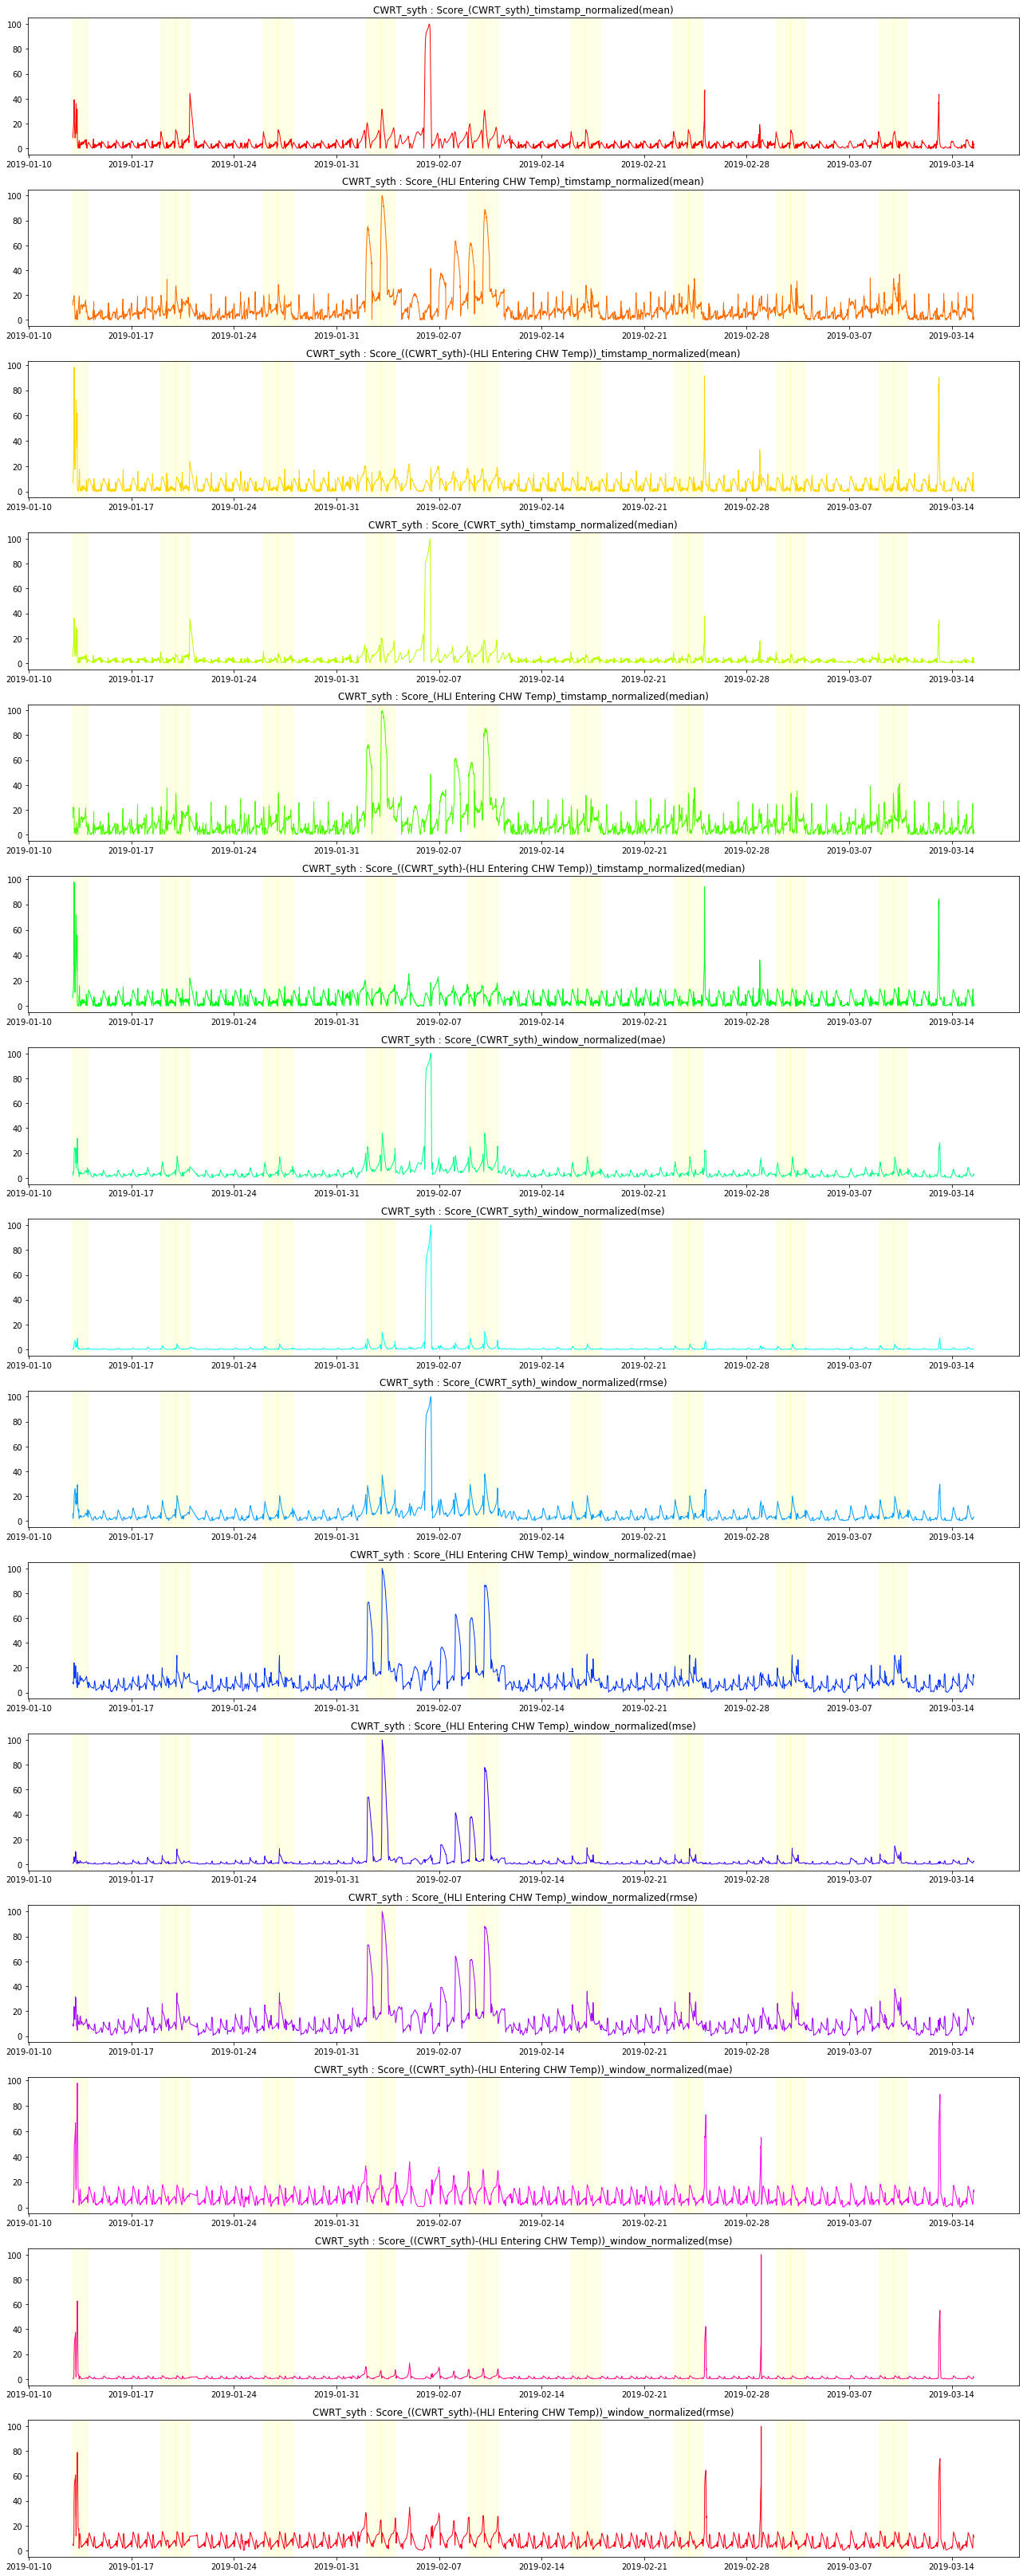

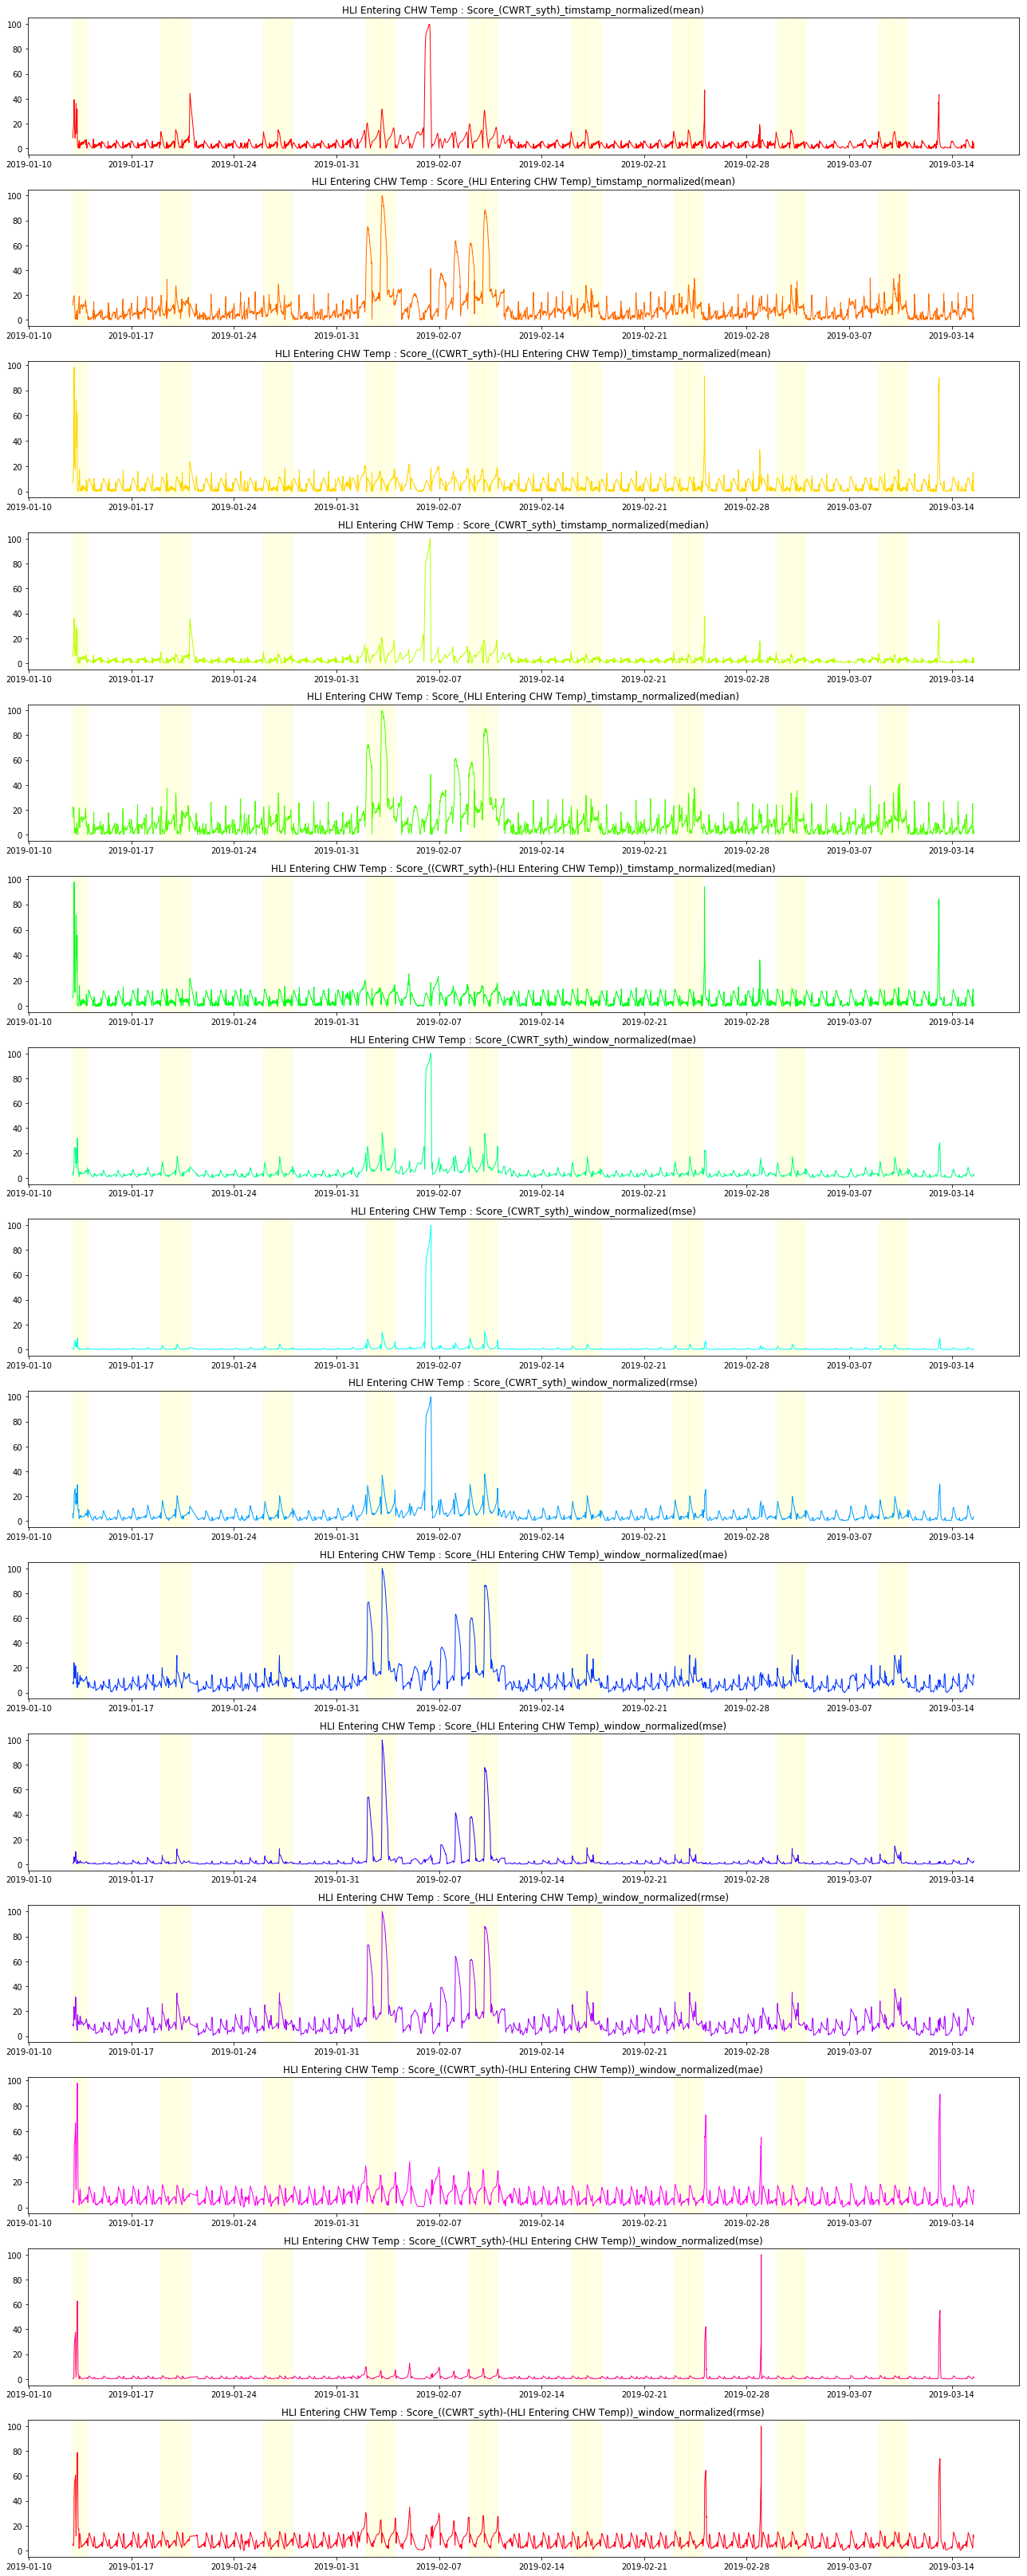

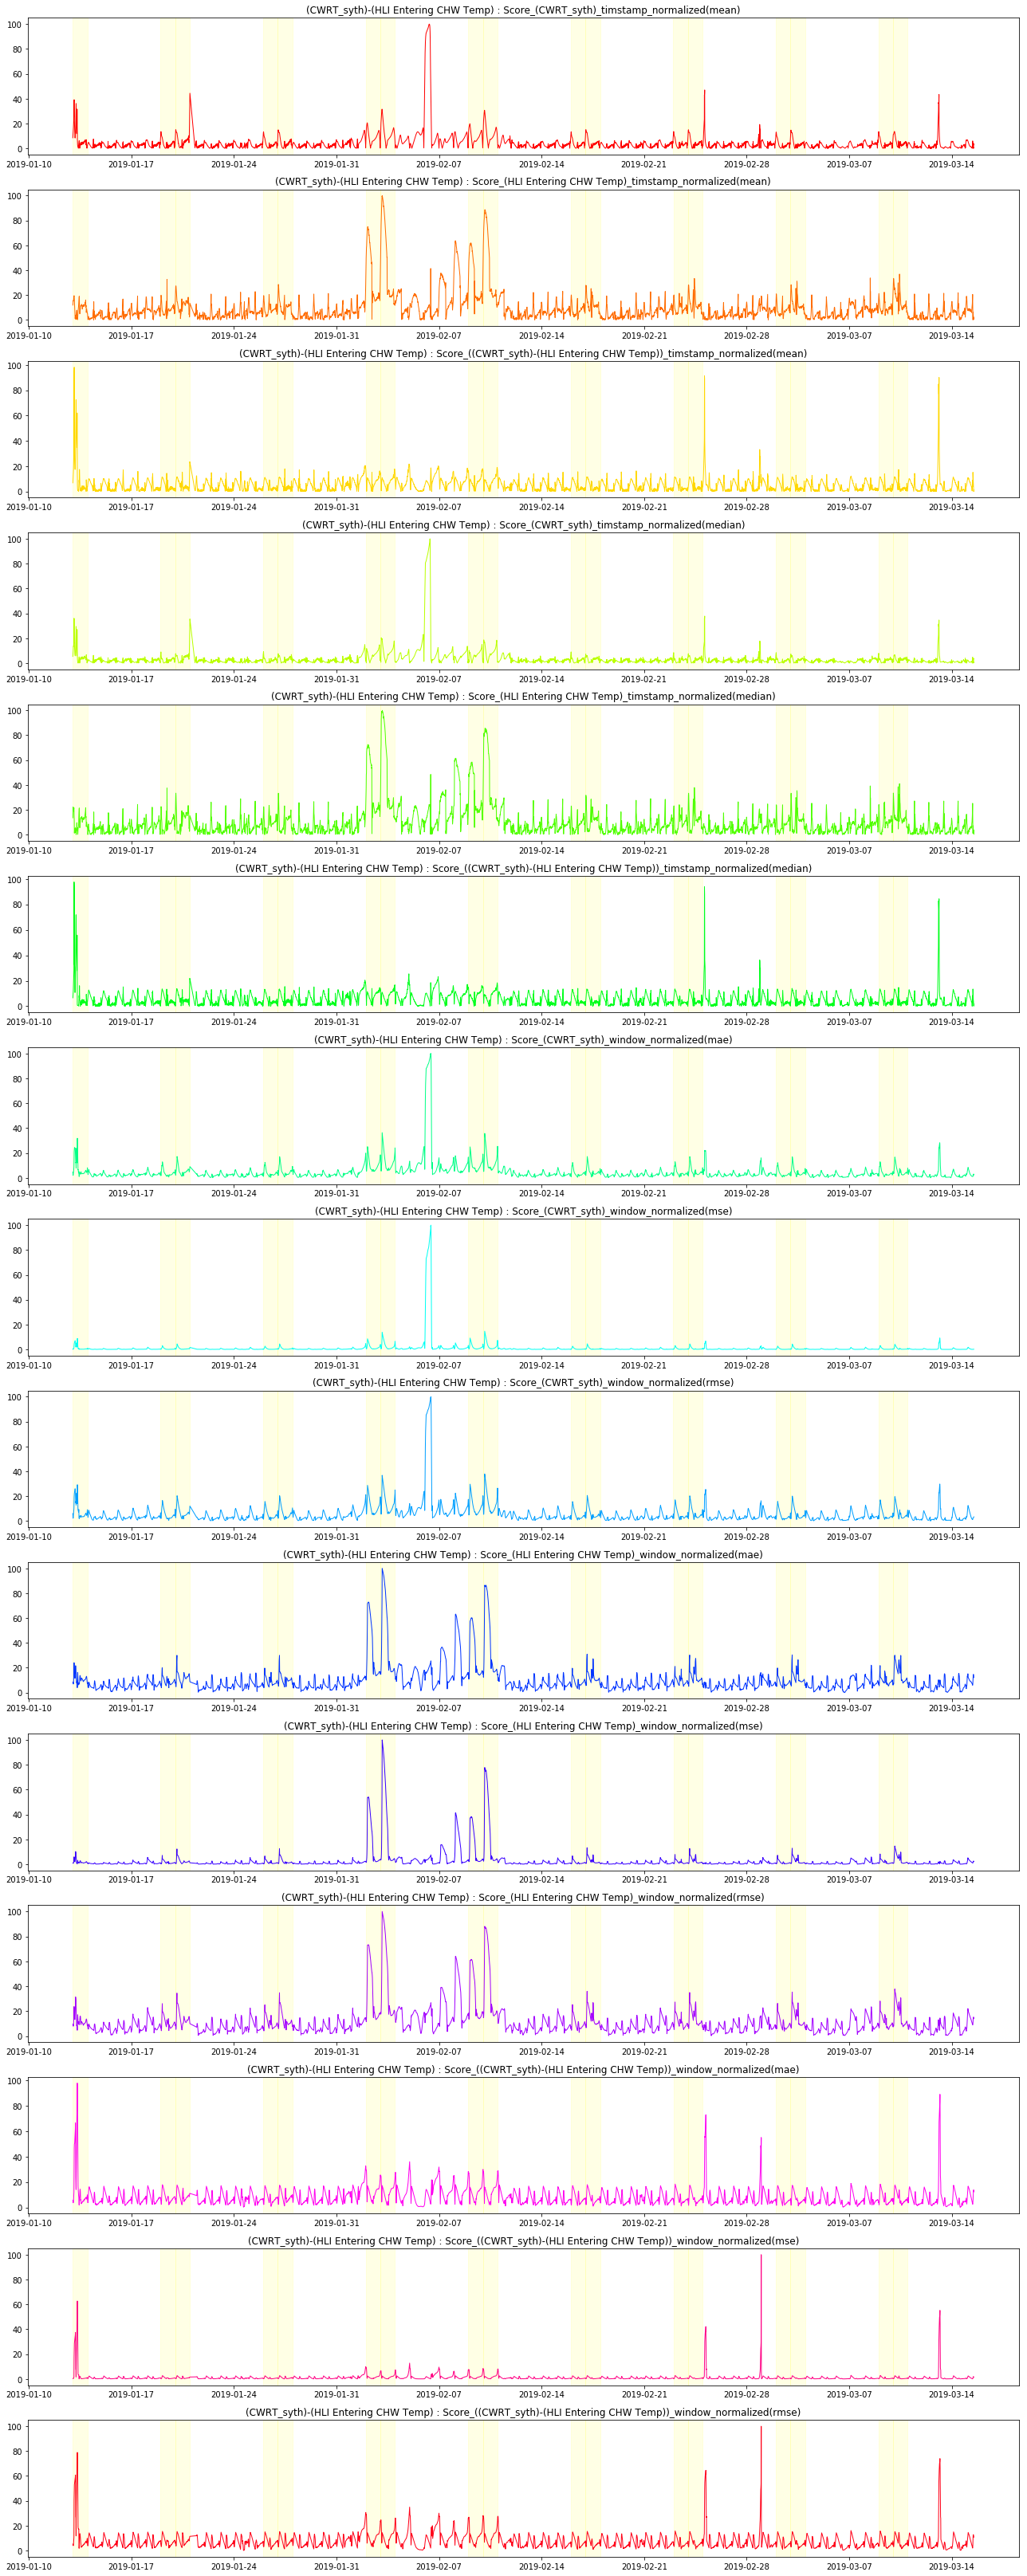

In [76]:
# ------------ compare scores ------------------
allscorecols = [c for c in list(data_2) if 'Score' in c]
colors = plt.cm.get_cmap("hsv", len(allscorecols))

for col in maincols+derivecol:
    plt.subplots(figsize=(18, 3*len(allscorecols)))
    for j in range(len(allscorecols)):
        plt.subplot(len(allscorecols), 1, j+1)
        pds = data_2[allscorecols[j]].dropna()
        plt.plot_date(pds.index, pds, 
                  c=colors(j),  markersize=1,  marker='', linewidth=1, linestyle='-')

        tmp = data_2.index.to_frame()
        tmp['wkday'] = data_2.index.weekday+1
        tmp['date'] = tmp.index.date
        allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
        i = 0
        for dt in allwknddate:
            alltm_dt = tmp[str(dt)].index
            if i == len(allwknddate)-1:
                plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
            else:
                plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
            i += 1

        plt.title(col+' : '+allscorecols[j])
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
    plt.tight_layout()
    plt.show()


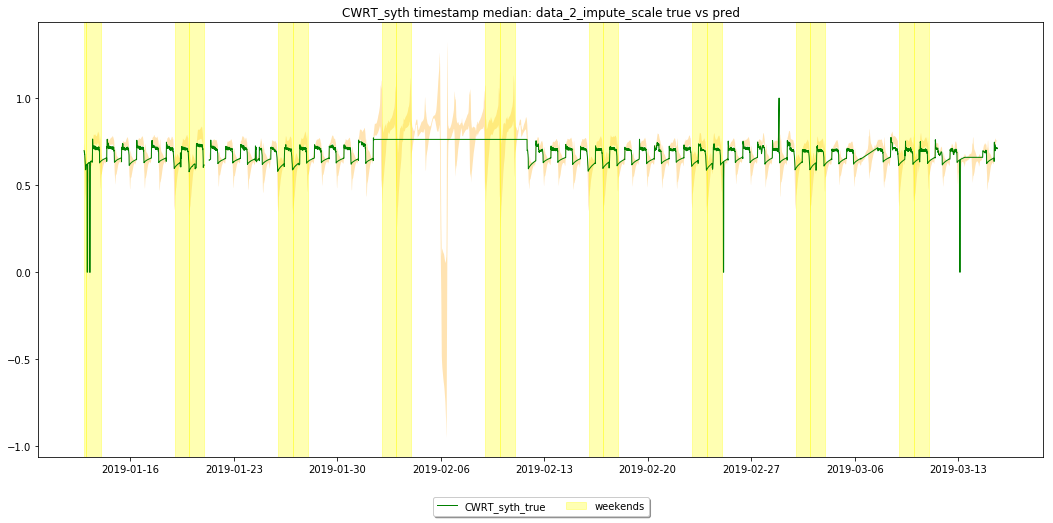

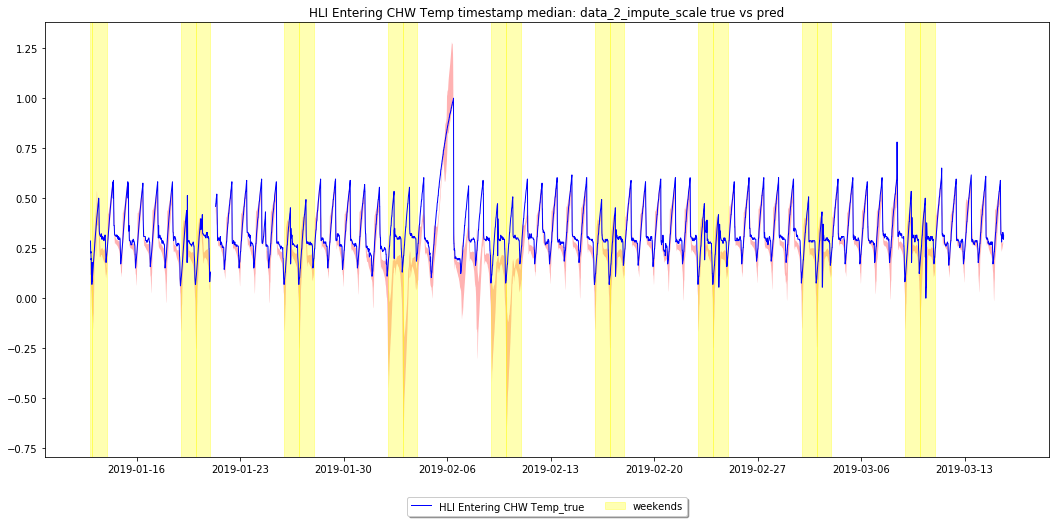

In [77]:
# ------------ compare true with pred ------------------
# allpredictions_1

for col, clr in zip(maincols, [['green', 'orange'], ['blue', 'red']]):
    plt.subplots(figsize=(18, 8))
    plt.plot_date(data_2_impute_scale.index, data_2_impute_scale[col], 
                  c=clr[0],  markersize=1,  marker='', linewidth=1, linestyle='-', label=col+'_true')
    
    plt.fill_between(allpredictions_1[col].index, 
                     allpredictions_1[col]['median']+allpredictions_1[col]['std'], 
                     allpredictions_1[col]['median']-allpredictions_1[col]['std'], 
                     facecolor=clr[1], alpha=0.3)

    tmp = data_2_impute_scale.index.to_frame()
    tmp['wkday'] = data_2_impute_scale.index.weekday+1
    tmp['date'] = tmp.index.date
    allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
    i = 0
    for dt in allwknddate:
        alltm_dt = tmp[str(dt)].index
        if i == len(allwknddate)-1:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow', label='weekends')
        else:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.3, color='yellow')
        i += 1
    
    plt.title(col+' timestamp median: data_2_impute_scale true vs pred')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
    plt.show()

### __*label outliers*__

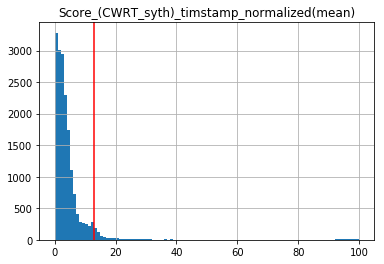

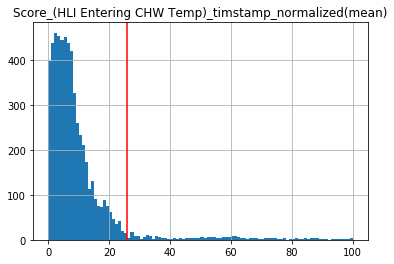

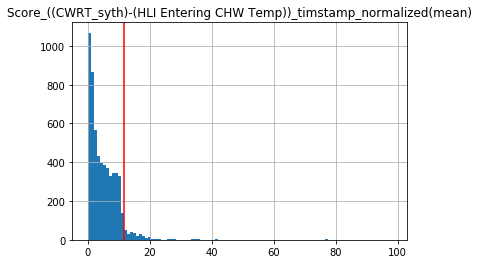

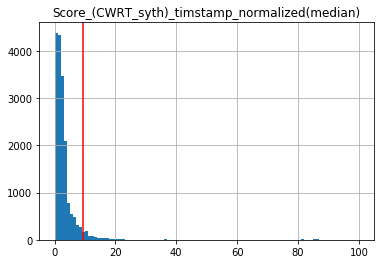

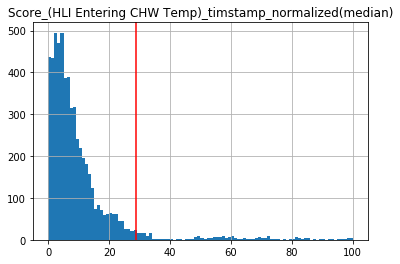

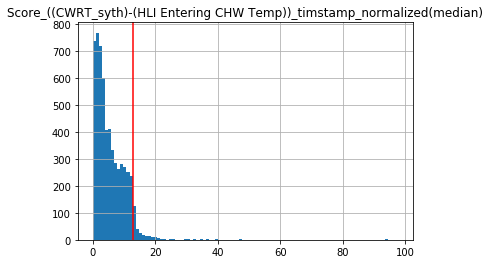

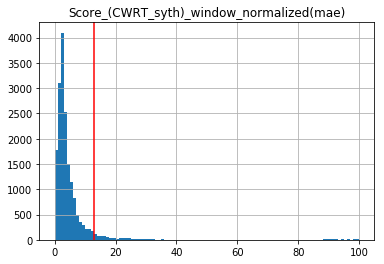

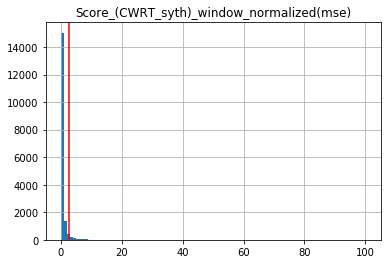

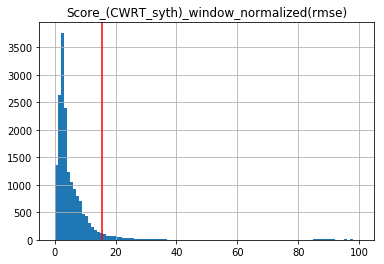

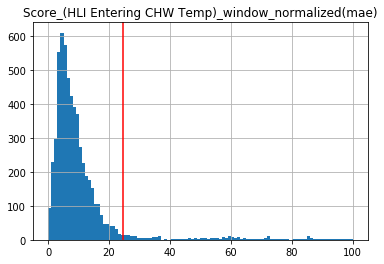

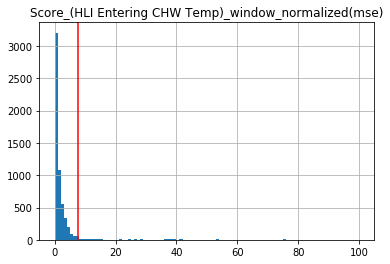

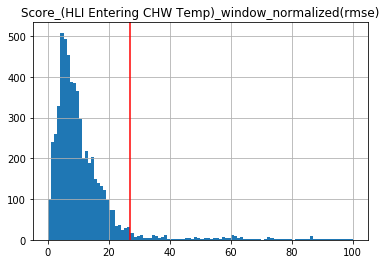

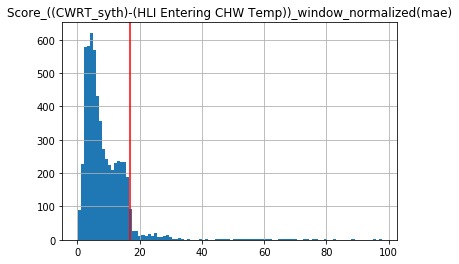

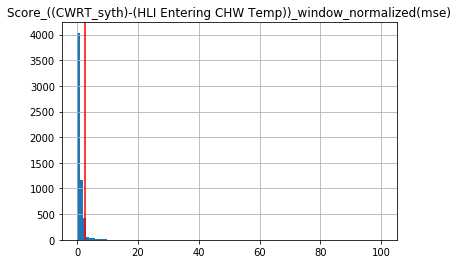

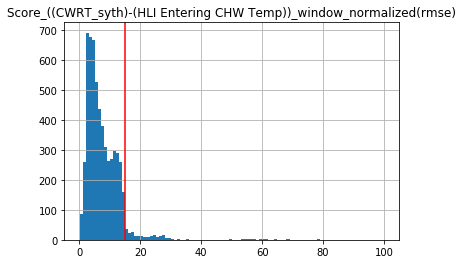

In [108]:
allscorecols = [c for c in list(data_2) if 'Score' in c]
pctoutlier = 0.05  # adjustable

# histogram plot of all scores: check score distribution
for c in allscorecols:
    thrshold = np.nanpercentile(data_2[c].values, (1-pctoutlier)*100)
    data_2[c].hist(bins=100)
    plt.axvline(x=thrshold, color='red')
    plt.title(c)
    plt.show()

In [79]:
pctoutlier = 0.05  # adjustable
allscorecols = [c for c in list(data_2) if 'Score' in c]

for col in allscorecols:
    thrshold = np.nanpercentile(data_2[col].values, (1-pctoutlier)*100)
    labelcolname = 'LABEL_'+col.replace('Score_', '')
    data_2[labelcolname] = False
    data_2.loc[data_2[col]>=thrshold, labelcolname]=True
    print(col+' anormaly count:')
    display(data_2[labelcolname].value_counts())

print('overal anomalyscore count:')  
display(data_2[['LABEL_'+col.replace('Score_', '') for col in allscorecols]].sum(axis=1).value_counts())

Score_(CWRT_syth)_timstamp_normalized(mean) anormaly count:


False    16838
True       881
Name: LABEL_(CWRT_syth)_timstamp_normalized(mean), dtype: int64

Score_(HLI Entering CHW Temp)_timstamp_normalized(mean) anormaly count:


False    17425
True       294
Name: LABEL_(HLI Entering CHW Temp)_timstamp_normalized(mean), dtype: int64

Score_((CWRT_syth)-(HLI Entering CHW Temp))_timstamp_normalized(mean) anormaly count:


False    17425
True       294
Name: LABEL_((CWRT_syth)-(HLI Entering CHW Temp))_timstamp_normalized(mean), dtype: int64

Score_(CWRT_syth)_timstamp_normalized(median) anormaly count:


False    16838
True       881
Name: LABEL_(CWRT_syth)_timstamp_normalized(median), dtype: int64

Score_(HLI Entering CHW Temp)_timstamp_normalized(median) anormaly count:


False    17425
True       294
Name: LABEL_(HLI Entering CHW Temp)_timstamp_normalized(median), dtype: int64

Score_((CWRT_syth)-(HLI Entering CHW Temp))_timstamp_normalized(median) anormaly count:


False    17425
True       294
Name: LABEL_((CWRT_syth)-(HLI Entering CHW Temp))_timstamp_normalized(median), dtype: int64

Score_(CWRT_syth)_window_normalized(mae) anormaly count:


False    16840
True       879
Name: LABEL_(CWRT_syth)_window_normalized(mae), dtype: int64

Score_(CWRT_syth)_window_normalized(mse) anormaly count:


False    16840
True       879
Name: LABEL_(CWRT_syth)_window_normalized(mse), dtype: int64

Score_(CWRT_syth)_window_normalized(rmse) anormaly count:


False    16840
True       879
Name: LABEL_(CWRT_syth)_window_normalized(rmse), dtype: int64

Score_(HLI Entering CHW Temp)_window_normalized(mae) anormaly count:


False    17426
True       293
Name: LABEL_(HLI Entering CHW Temp)_window_normalized(mae), dtype: int64

Score_(HLI Entering CHW Temp)_window_normalized(mse) anormaly count:


False    17426
True       293
Name: LABEL_(HLI Entering CHW Temp)_window_normalized(mse), dtype: int64

Score_(HLI Entering CHW Temp)_window_normalized(rmse) anormaly count:


False    17426
True       293
Name: LABEL_(HLI Entering CHW Temp)_window_normalized(rmse), dtype: int64

Score_((CWRT_syth)-(HLI Entering CHW Temp))_window_normalized(mae) anormaly count:


False    17426
True       293
Name: LABEL_((CWRT_syth)-(HLI Entering CHW Temp))_window_normalized(mae), dtype: int64

Score_((CWRT_syth)-(HLI Entering CHW Temp))_window_normalized(mse) anormaly count:


False    17426
True       293
Name: LABEL_((CWRT_syth)-(HLI Entering CHW Temp))_window_normalized(mse), dtype: int64

Score_((CWRT_syth)-(HLI Entering CHW Temp))_window_normalized(rmse) anormaly count:


False    17426
True       293
Name: LABEL_((CWRT_syth)-(HLI Entering CHW Temp))_window_normalized(rmse), dtype: int64

overal anomalyscore count:


0     15582
1       532
3       403
5       384
2       377
4       132
7        80
6        73
8        64
9        45
10       43
11        3
12        1
dtype: int64

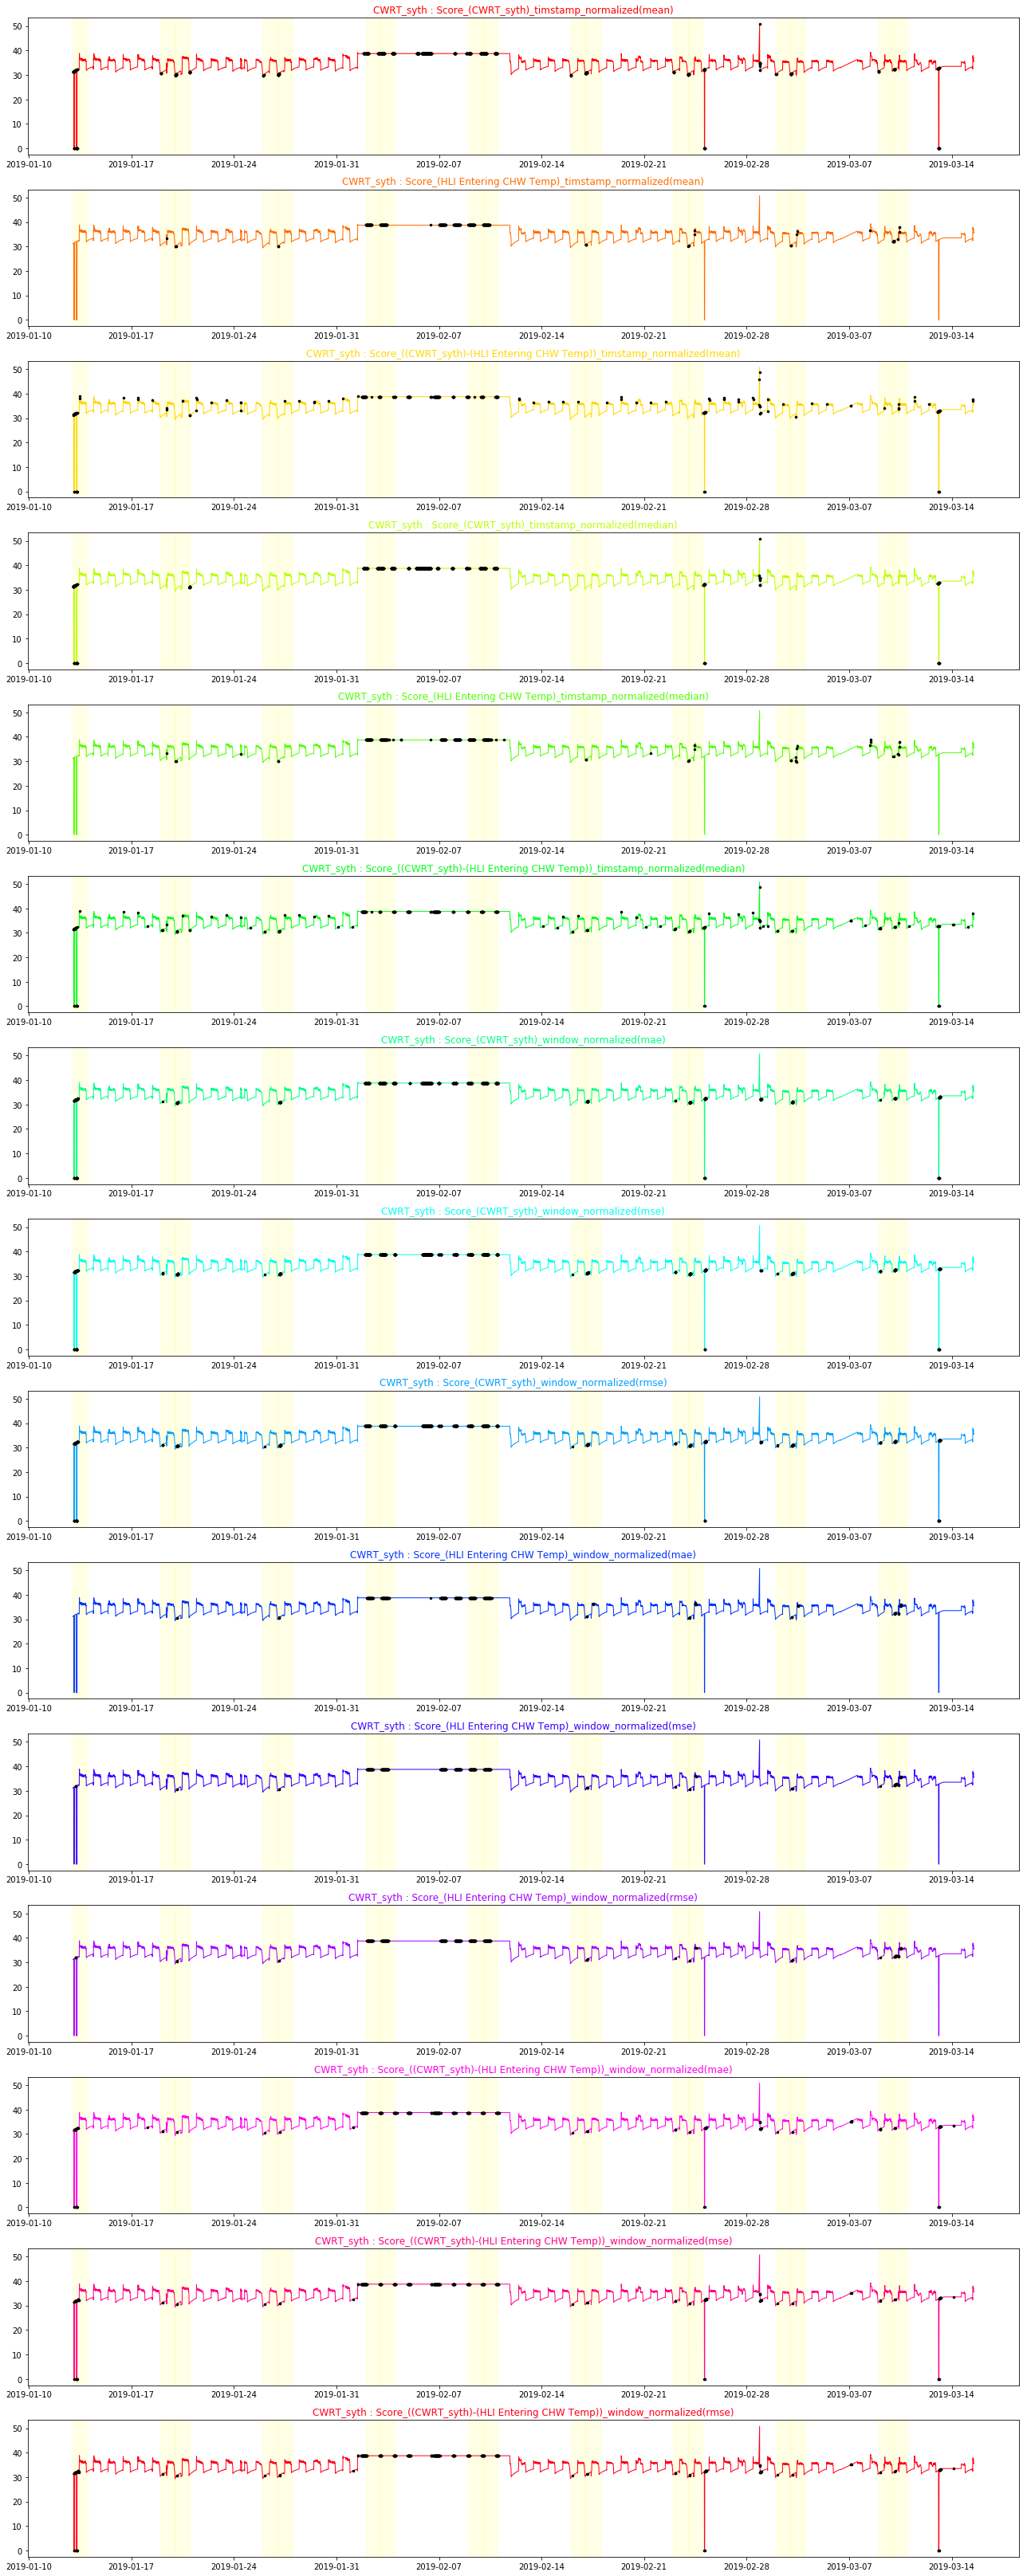

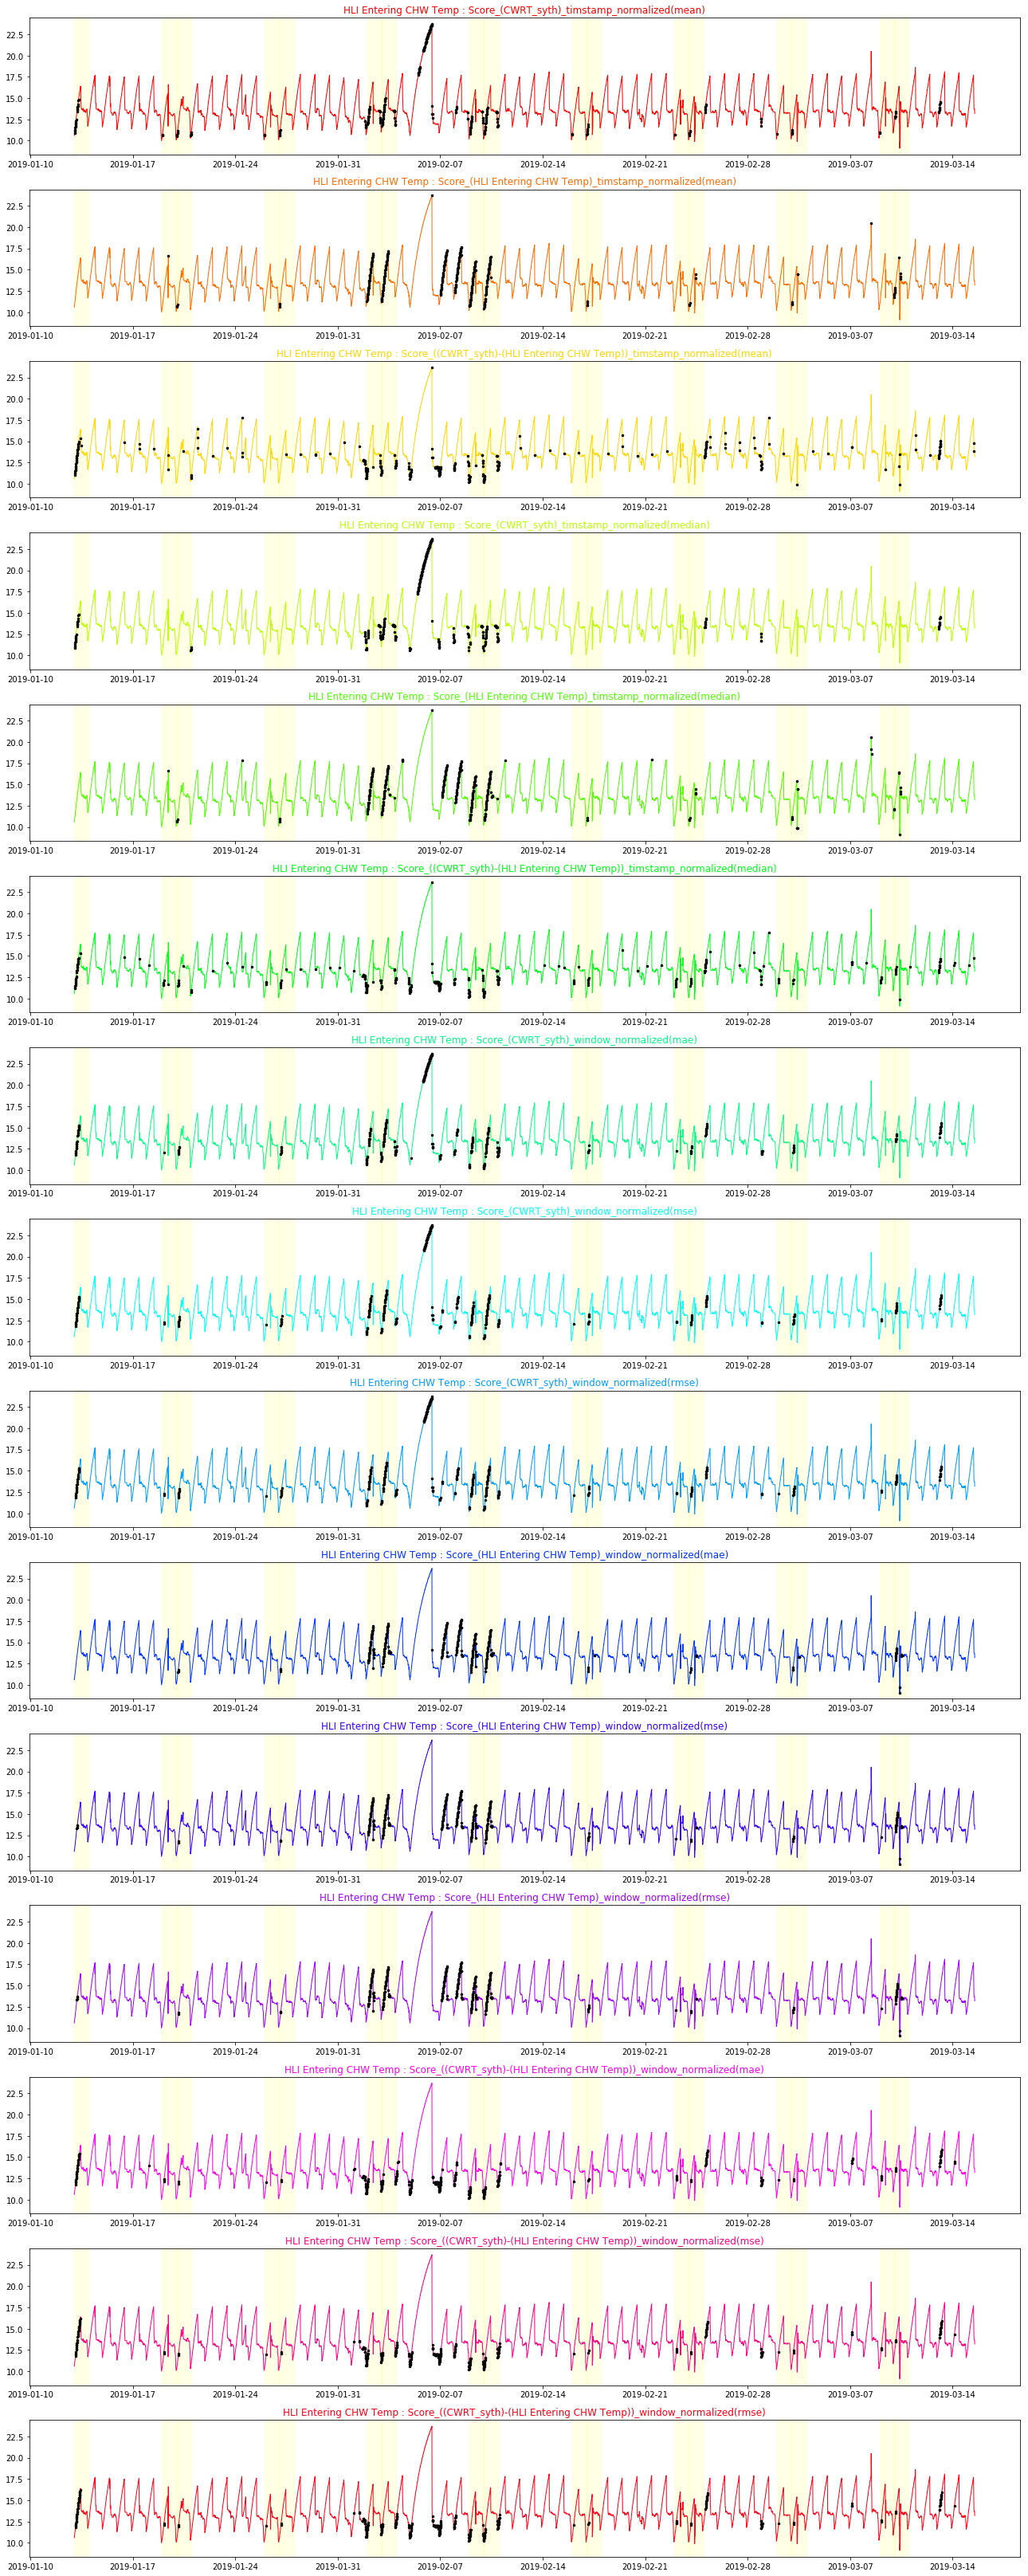

In [80]:
# ------------ plot outliers: maincols ------------------
alllabelcols = [c for c in list(data_2) if ('normalized' in c.lower()) and ('label' in c.lower())]
colors = plt.cm.get_cmap("hsv", len(allscorecols))

for col in maincols:
    plt.subplots(figsize=(18, 3*len(allscorecols)))
    for j in range(len(alllabelcols)):
        plt.subplot(len(alllabelcols), 1, j+1)
        
        pds = data_2[col].dropna()
        plt.plot_date(pds.index, pds, c=colors(j),  marker='', linewidth=1, linestyle='-')
        pds_anmly = data_2.loc[data_2[alllabelcols[j]], col].dropna()
        plt.plot_date(pds_anmly.index, pds_anmly, c='black',  markersize=5,  marker='.', linestyle='')        

        tmp = data_2.index.to_frame()
        tmp['wkday'] = data_2.index.weekday+1
        tmp['date'] = tmp.index.date
        allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
        i = 0
        for dt in allwknddate:
            alltm_dt = tmp[str(dt)].index
            if i == len(allwknddate)-1:
                plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
            else:
                plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
            i += 1

        plt.title(col+' : '+allscorecols[j], color=colors(j))
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
    plt.tight_layout()
    plt.show()


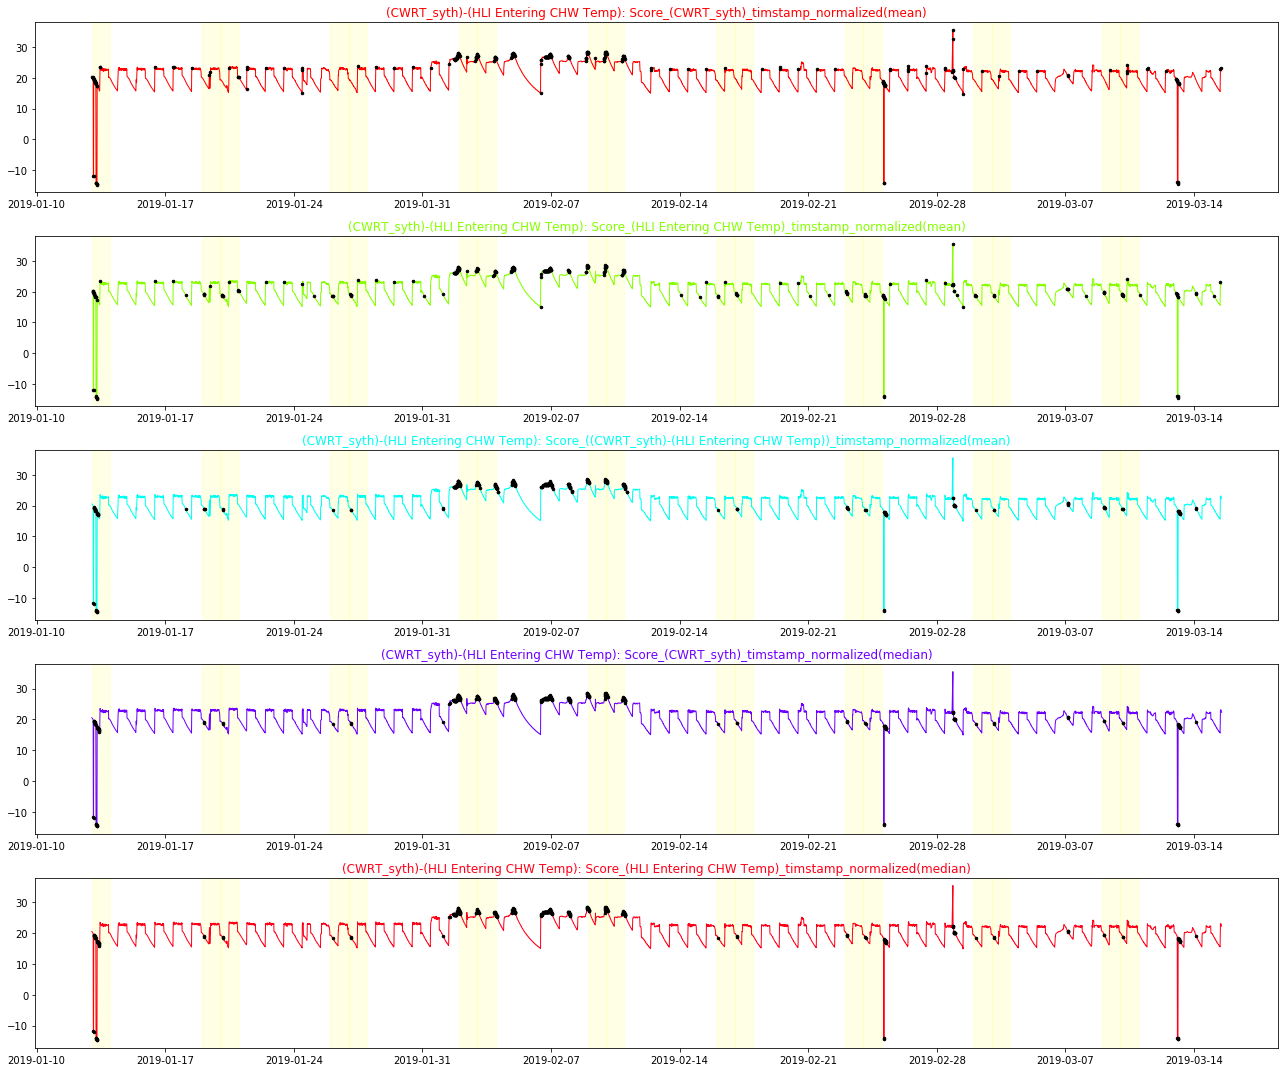

In [91]:
# ------------ plot outliers: (CWRT_syth)-(HLI Entering CHW Temp) ------------------
alllabelcols = [c for c in list(data_2) if ('normalized' in c.lower()) and 
                ('label' in c.lower()) and ('(CWRT_syth)-(HLI Entering CHW Temp)' in c)]
colors = plt.cm.get_cmap("hsv", len(alllabelcols))

t_diff = data_2[maincols+alllabelcols].copy()
col = '(CWRT_syth)-(HLI Entering CHW Temp)'
t_diff[col] = t_diff['CWRT_syth'] - t_diff['HLI Entering CHW Temp']

plt.subplots(figsize=(18, 3*len(alllabelcols)))
for j in range(len(alllabelcols)):
    plt.subplot(len(alllabelcols), 1, j+1)

    pds = t_diff[col].dropna()
    plt.plot_date(pds.index, pds, c=colors(j),  marker='', linewidth=1, linestyle='-')
    
    pds_anmly = t_diff.loc[t_diff[alllabelcols[j]], col].dropna()
    plt.plot_date(pds_anmly.index, pds_anmly, c='black',  markersize=5,  marker='.', linestyle='')        

    tmp = t_diff.index.to_frame()
    tmp['wkday'] = t_diff.index.weekday+1
    tmp['date'] = tmp.index.date
    allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
    i = 0
    for dt in allwknddate:
        alltm_dt = tmp[str(dt)].index
        if i == len(allwknddate)-1:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
        else:
            plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
        i += 1

    plt.title(col+': '+allscorecols[j], color=colors(j))
plt.tight_layout()
plt.show()


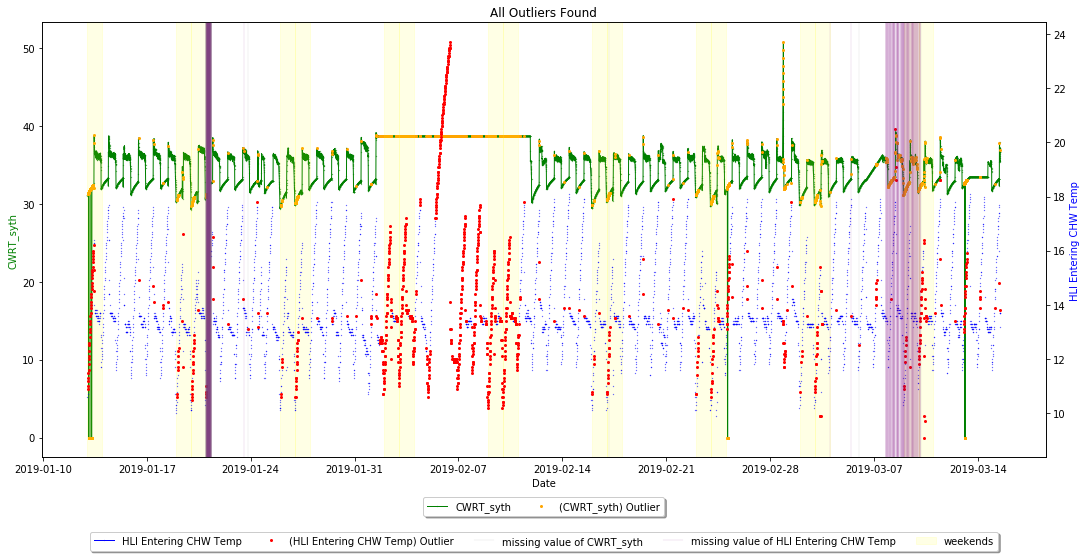

In [99]:
# ------------ plot outliers: all the outliers combine ------------------

fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

# outliers (without consideration of daily profile)
cond = data_2[[c for c in list(data_2) if ('label' in c.lower() and ('_profile' not in c))]].sum(axis=1)>0

for col, clr, ax_ in zip(maincols, [['green', 'orange'], ['blue', 'red']], [ax1, ax2]):
    
    ax_.plot_date(data_2.index, data_2[col], c=clr[0], markersize=0.5, marker='.', 
                  linewidth=1, linestyle='-', label=col)
    ax_.set_ylabel(col, color=clr[0])
    ax_.set_xlabel('Date')

    sub1 = data_2[cond].copy()
    ax_.plot_date(sub1.index, sub1[col], c=clr[1], markersize=4, marker='.', 
                  linewidth=1, linestyle='', label='('+col+') Outlier')

tmp = data_2.index.to_frame()
tmp['wkday'] = data_2.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
    i += 1


# missing value outliers
for col, clr in zip(maincols, ['grey', 'purple']):
    ts_missing = list(data_2[data_2['LABEL_('+col+')_(wrong_gap)']].index)
    i=0
    for dt in ts_missing:
        if i == len(ts_missing)-1:
            plt.axvline(dt, alpha=1, color=clr, linestyle='-', linewidth=0.1, label='missing value of '+col)
        else:
            plt.axvline(dt, alpha=1, linestyle='-', linewidth=0.1, color=clr)
        i += 1
        
        
plt.title('All Outliers Found')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.show()


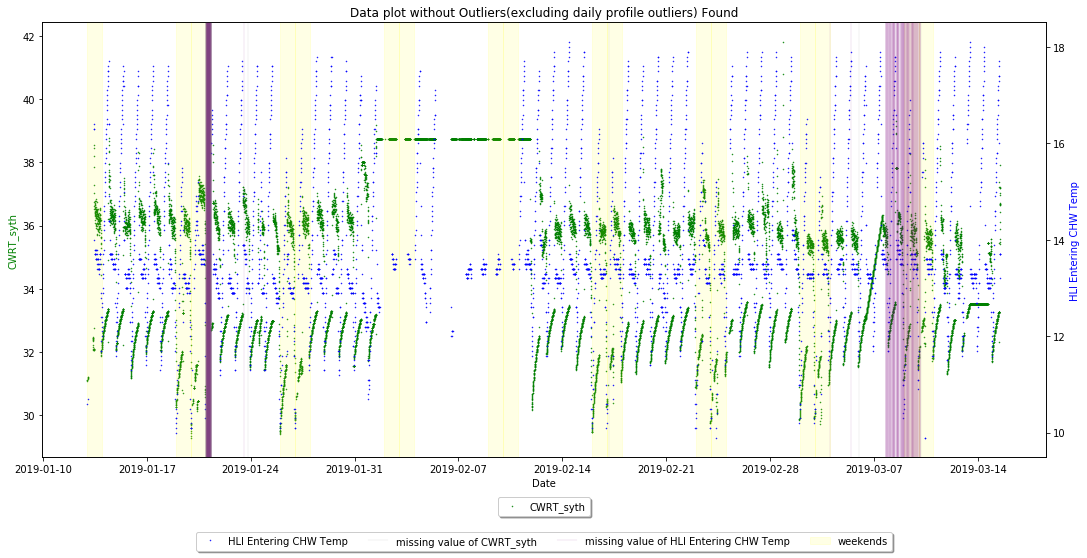

In [102]:
# ------------ plot outliers: without outliers (excluding daily profile) ------------------

fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

# outliers (without consideration of daily profile)
cond = data_2[[c for c in list(data_2) if ('label' in c.lower() and ('_profile' not in c))]].sum(axis=1)==0
sub1 = data_2[cond].copy()

for col, clr, ax_ in zip(maincols, ['green', 'blue'], [ax1, ax2]):
    ax_.plot_date(sub1.index, sub1[col], c=clr, markersize=1, marker='.', 
                  linewidth=1, linestyle='', label=col)
    ax_.set_ylabel(col, color=clr)
    ax_.set_xlabel('Date')

tmp = data_2.index.to_frame()
tmp['wkday'] = data_2.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
    i += 1


# missing value outliers
for col, clr in zip(maincols, ['grey', 'purple']):
    ts_missing = list(data_2[data_2['LABEL_('+col+')_(wrong_gap)']].index)
    i=0
    for dt in ts_missing:
        if i == len(ts_missing)-1:
            plt.axvline(dt, alpha=1, color=clr, linestyle='-', linewidth=0.1, label='missing value of '+col)
        else:
            plt.axvline(dt, alpha=1, linestyle='-', linewidth=0.1, color=clr)
        i += 1

plt.title('Data plot without Outliers(excluding daily profile outliers) Found')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.show()


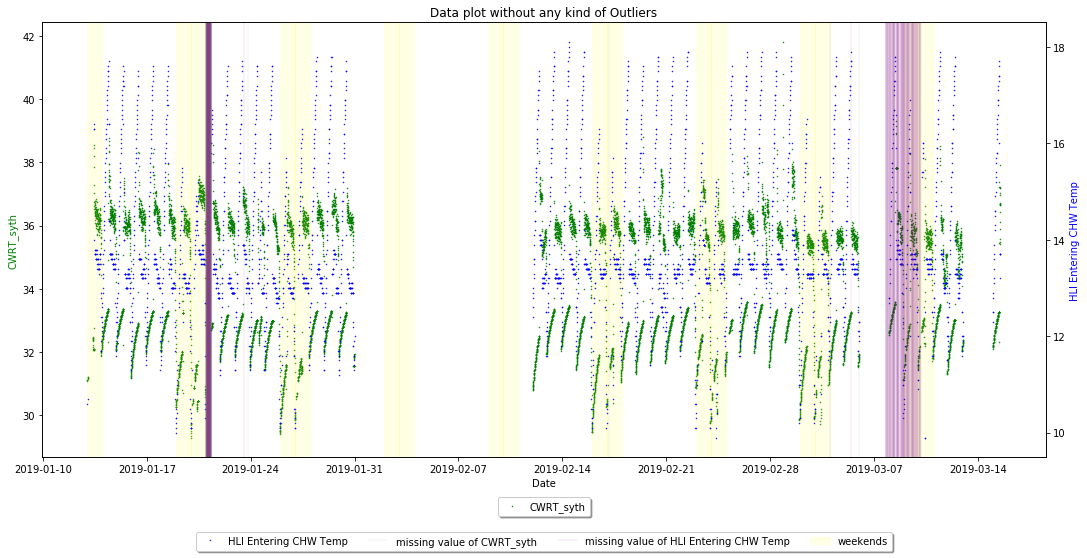

In [103]:
# ------------ plot outliers: without outliers ------------------

fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

# outliers (without consideration of daily profile)
cond = data_2[[c for c in list(data_2) if ('label' in c.lower())]].sum(axis=1)==0
sub1 = data_2[cond].copy()

for col, clr, ax_ in zip(maincols, ['green', 'blue'], [ax1, ax2]):
    ax_.plot_date(sub1.index, sub1[col], c=clr, markersize=1, marker='.', 
                  linewidth=1, linestyle='', label=col)
    ax_.set_ylabel(col, color=clr)
    ax_.set_xlabel('Date')

tmp = data_2.index.to_frame()
tmp['wkday'] = data_2.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
    i += 1


# missing value outliers
for col, clr in zip(maincols, ['grey', 'purple']):
    ts_missing = list(data_2[data_2['LABEL_('+col+')_(wrong_gap)']].index)
    i=0
    for dt in ts_missing:
        if i == len(ts_missing)-1:
            plt.axvline(dt, alpha=1, color=clr, linestyle='-', linewidth=0.1, label='missing value of '+col)
        else:
            plt.axvline(dt, alpha=1, linestyle='-', linewidth=0.1, color=clr)
        i += 1

plt.title('Data plot without any kind of Outliers')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.show()


In [100]:
data_2.to_csv('data_3.csv', index=True)

## Combine all Scores

In [218]:
data_final = data_2.copy()
allscorecols = [c for c in list(data_final) if 'score' in c.lower()]
alllabelcols = [c for c in list(data_final) if 'label' in c.lower()]

In [219]:
for col in maincols:
    data_final['Final_OutlierScore_('+col+')'] = data_final[
        [c for c in list(data_final) if ('score' in c.lower()) and (col in c)]].sum(axis=1) + \
    data_final['LABEL_('+col+')_(extreme_value)'].replace(True, 200).replace(False, 0) + \
    data_final['LABEL_('+col+'_profile)_(outlier)'].replace(True, 200).replace(False, 0)

data_final['Final_OutlierScore_(AllColumns)'] = data_final[
    [c for c in list(data_final) if 'score' in c.lower()]].sum(axis=1)+ \
    data_final[['LABEL_('+c+')_(extreme_value)' for c in maincols]].replace(
    True, 200).replace(False, 0).sum(axis=1) + \
    data_final[['LABEL_('+c+'_profile)_(outlier)' for c in maincols]].replace(
    True, 200).replace(False, 0).sum(axis=1)

data_final = data_final.drop(
    ['day'] + timecols + \
    [c for c in list(data_final) if ('score' in c.lower()) & ('Final_OutlierScore_' not in c)]+\
    ['LABEL_('+c+')_(extreme_value)' for c in maincols] + \
    ['LABEL_('+c+'_profile)_(outlier)' for c in maincols], axis=1)

display(data_final.describe())
display(data_final.head())


CWRT_syth  HLI Entering CHW Temp  Final_OutlierScore_(CWRT_syth)  \
count  17615.000000            5868.000000                    17719.000000   
mean      34.761378              13.929772                       77.993466   
std        3.042954               1.861147                      108.582989   
min        0.000000               9.100000                        0.000000   
25%       32.669998              13.000000                       10.378960   
50%       35.330001              13.500000                       20.790971   
75%       36.368999              14.800000                      107.788508   
max       50.804002              23.700001                      869.488060   

       Final_OutlierScore_(HLI Entering CHW Temp)  \
count                                17719.000000   
mean                                    41.280742   
std                                     78.920322   
min                                      0.000000   
25%                                      0.000000   
50%                                      0.000000   
75%                                     51.205771   
max                                    586.493042   

       Final_OutlierScore_(AllColumns)  
count                     17719.000000  
mean                        229.303954  
std                         323.149987  
min                           0.000000  
25%                          21.242554  
50%                          69.712817  
75%                         408.768873  
max                        2373.089581

Date   Time  CWRT_syth  HLI Entering CHW Temp  \
timestamp                                                                  
2019-01-13 00:00:00  2019-01-13  0000h  31.090000                    NaN   
2019-01-13 00:05:00  2019-01-13  0005h  31.106000                    NaN   
2019-01-13 00:10:00  2019-01-13  0010h  31.129999                   10.6   
2019-01-13 00:15:00  2019-01-13  0015h  31.146000                    NaN   
2019-01-13 00:20:00  2019-01-13  0020h  31.170000                    NaN   

                     LABEL_(CWRT_syth)_(wrong_gap)  \
timestamp                                            
2019-01-13 00:00:00                          False   
2019-01-13 00:05:00                          False   
2019-01-13 00:10:00                          False   
2019-01-13 00:15:00                          False   
2019-01-13 00:20:00                          False   

                     LABEL_(HLI Entering CHW Temp)_(wrong_gap)  \
timestamp                                                        
2019-01-13 00:00:00                                      False   
2019-01-13 00:05:00                                      False   
2019-01-13 00:10:00                                      False   
2019-01-13 00:15:00                                      False   
2019-01-13 00:20:00                                      False   

                     LABEL_(CWRT_syth)_timstamp_normalized(mean)  \
timestamp                                                          
2019-01-13 00:00:00                                        False   
2019-01-13 00:05:00                                        False   
2019-01-13 00:10:00                                        False   
2019-01-13 00:15:00                                        False   
2019-01-13 00:20:00                                        False   

                     LABEL_(HLI Entering CHW Temp)_timstamp_normalized(mean)  \
timestamp                                                                      
2019-01-13 00:00:00                                              False         
2019-01-13 00:05:00                                              False         
2019-01-13 00:10:00                                              False         
2019-01-13 00:15:00                                              False         
2019-01-13 00:20:00                                              False         

                     LABEL_((CWRT_syth)-(HLI Entering CHW Temp))_timstamp_normalized(mean)  \
timestamp                                                                                    
2019-01-13 00:00:00                                              False                       
2019-01-13 00:05:00                                              False                       
2019-01-13 00:10:00                                              False                       
2019-01-13 00:15:00                                              False                       
2019-01-13 00:20:00                                              False                       

                     LABEL_(CWRT_syth)_timstamp_normalized(median)  \
timestamp                                                            
2019-01-13 00:00:00                                          False   
2019-01-13 00:05:00                                          False   
2019-01-13 00:10:00                                          False   
2019-01-13 00:15:00                                          False   
2019-01-13 00:20:00                                          False   

                     LABEL_(HLI Entering CHW Temp)_timstamp_normalized(median)  \
timestamp                                                                        
2019-01-13 00:00:00                                              False           
2019-01-13 00:05:00                                              False           
2019-01-13 00:10:00                                              False           
2019-01-13 00:15:00                                   

In [220]:
for col in maincols:
    data_final.loc[data_final[col].isna(), 'Final_OutlierScore_('+col+')'] = np.nan    

data_final.loc[data_final[maincols].isna().sum(axis=1)>0, 'Final_OutlierScore_(AllColumns)'] = np.nan      
    
    
# normalize
for sc in [c for c in list(data_final) if 'Final_OutlierScore_' in c]:
    tmp = data_final[sc].copy()
    mtc_min = tmp.min()
    mtc_max = tmp.max()
    data_final[sc] = 100.0*(tmp-mtc_min).div(mtc_max-mtc_min)
    
print(data_final.shape)
display(data_final.describe())
display(data_final.head())    

(17719, 24)


CWRT_syth  HLI Entering CHW Temp  Final_OutlierScore_(CWRT_syth)  \
count  17615.000000            5868.000000                    17615.000000   
mean      34.761378              13.929772                        9.021698   
std        3.042954               1.861147                       12.505614   
min        0.000000               9.100000                        0.000000   
25%       32.669998              13.000000                        1.207118   
50%       35.330001              13.500000                        2.410413   
75%       36.368999              14.800000                       14.447758   
max       50.804002              23.700001                      100.000000   

       Final_OutlierScore_(HLI Entering CHW Temp)  \
count                                 5868.000000   
mean                                    15.178889   
std                                     16.232750   
min                                      0.000000   
25%                                      6.045236   
50%                                      9.513751   
75%                                     15.406743   
max                                    100.000000   

       Final_OutlierScore_(AllColumns)  
count                      5865.000000  
mean                         14.098159  
std                          16.005486  
min                           0.000000  
25%                           4.198555  
50%                           6.947307  
75%                          20.013542  
max                         100.000000

Date   Time  CWRT_syth  HLI Entering CHW Temp  \
timestamp                                                                  
2019-01-13 00:00:00  2019-01-13  0000h  31.090000                    NaN   
2019-01-13 00:05:00  2019-01-13  0005h  31.106000                    NaN   
2019-01-13 00:10:00  2019-01-13  0010h  31.129999                   10.6   
2019-01-13 00:15:00  2019-01-13  0015h  31.146000                    NaN   
2019-01-13 00:20:00  2019-01-13  0020h  31.170000                    NaN   

                     LABEL_(CWRT_syth)_(wrong_gap)  \
timestamp                                            
2019-01-13 00:00:00                          False   
2019-01-13 00:05:00                          False   
2019-01-13 00:10:00                          False   
2019-01-13 00:15:00                          False   
2019-01-13 00:20:00                          False   

                     LABEL_(HLI Entering CHW Temp)_(wrong_gap)  \
timestamp                                                        
2019-01-13 00:00:00                                      False   
2019-01-13 00:05:00                                      False   
2019-01-13 00:10:00                                      False   
2019-01-13 00:15:00                                      False   
2019-01-13 00:20:00                                      False   

                     LABEL_(CWRT_syth)_timstamp_normalized(mean)  \
timestamp                                                          
2019-01-13 00:00:00                                        False   
2019-01-13 00:05:00                                        False   
2019-01-13 00:10:00                                        False   
2019-01-13 00:15:00                                        False   
2019-01-13 00:20:00                                        False   

                     LABEL_(HLI Entering CHW Temp)_timstamp_normalized(mean)  \
timestamp                                                                      
2019-01-13 00:00:00                                              False         
2019-01-13 00:05:00                                              False         
2019-01-13 00:10:00                                              False         
2019-01-13 00:15:00                                              False         
2019-01-13 00:20:00                                              False         

                     LABEL_((CWRT_syth)-(HLI Entering CHW Temp))_timstamp_normalized(mean)  \
timestamp                                                                                    
2019-01-13 00:00:00                                              False                       
2019-01-13 00:05:00                                              False                       
2019-01-13 00:10:00                                              False                       
2019-01-13 00:15:00                                              False                       
2019-01-13 00:20:00                                              False                       

                     LABEL_(CWRT_syth)_timstamp_normalized(median)  \
timestamp                                                            
2019-01-13 00:00:00                                          False   
2019-01-13 00:05:00                                          False   
2019-01-13 00:10:00                                          False   
2019-01-13 00:15:00                                          False   
2019-01-13 00:20:00                                          False   

                     LABEL_(HLI Entering CHW Temp)_timstamp_normalized(median)  \
timestamp                                                                        
2019-01-13 00:00:00                                              False           
2019-01-13 00:05:00                                              False           
2019-01-13 00:10:00                                              False           
2019-01-13 00:15:00                                   

In [221]:
data_final.to_csv('data_final.csv', index=True)

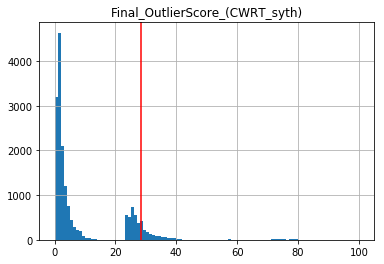

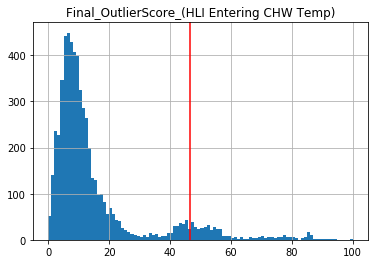

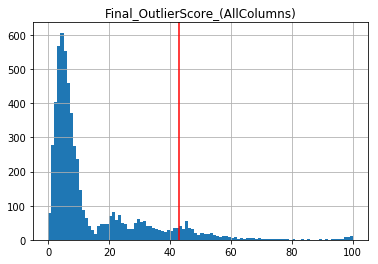

In [222]:
# ------------ plot score distribution ------------
allscorecols = [c for c in list(data_final) if 'Score' in c]
pctoutlier = 0.08  # adjustable

score_cutoff = {}
# histogram plot of all scores: check score distribution
for c in allscorecols:
    thrshold = np.nanpercentile(data_final[c].values, (1-pctoutlier)*100)
    score_cutoff[c] = thrshold
    data_final[c].hist(bins=100)
    plt.axvline(x=thrshold, color='red')
    plt.title(c)
    plt.show()

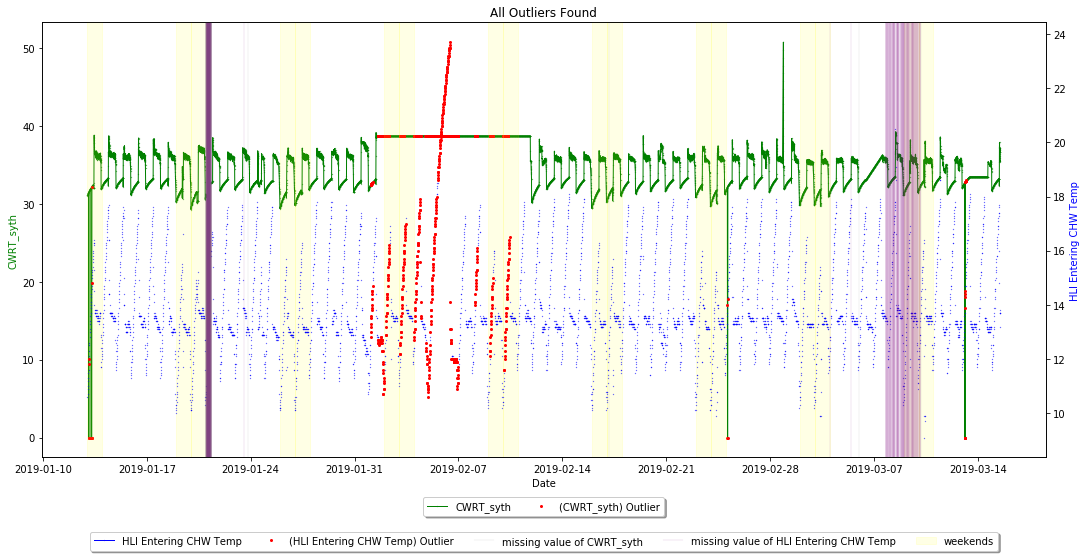

In [223]:
# ------------ plot outliers: all the outliers combine ------------------

fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

for col, clr, ax_ in zip(maincols, [['green', 'red'], ['blue', 'red']], [ax1, ax2]):
    
    ax_.plot_date(data_final.index, data_final[col], c=clr[0], markersize=0.5, marker='.', 
                  linewidth=1, linestyle='-', label=col)
    ax_.set_ylabel(col, color=clr[0])
    ax_.set_xlabel('Date')

    # outliers 
    cond=1
    for cx in ['Final_OutlierScore_('+col+')', 'Final_OutlierScore_(AllColumns)']:
        cond = cond & (data_final[cx]>score_cutoff[cx])
    sub1 = data_final[cond].copy()
    ax_.plot_date(sub1.index, sub1[col], c=clr[1], markersize=4, marker='.', 
                  linewidth=1, linestyle='', label='('+col+') Outlier')

tmp = data_final.index.to_frame()
tmp['wkday'] = data_final.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
    i += 1


# missing value outliers
for col, clr in zip(maincols, ['grey', 'purple']):
    ts_missing = list(data_final[data_final['LABEL_('+col+')_(wrong_gap)']].index)
    i=0
    for dt in ts_missing:
        if i == len(ts_missing)-1:
            plt.axvline(dt, alpha=1, color=clr, linestyle='-', linewidth=0.1, label='missing value of '+col)
        else:
            plt.axvline(dt, alpha=1, linestyle='-', linewidth=0.1, color=clr)
        i += 1
        
        
plt.title('All Outliers Found')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.show()



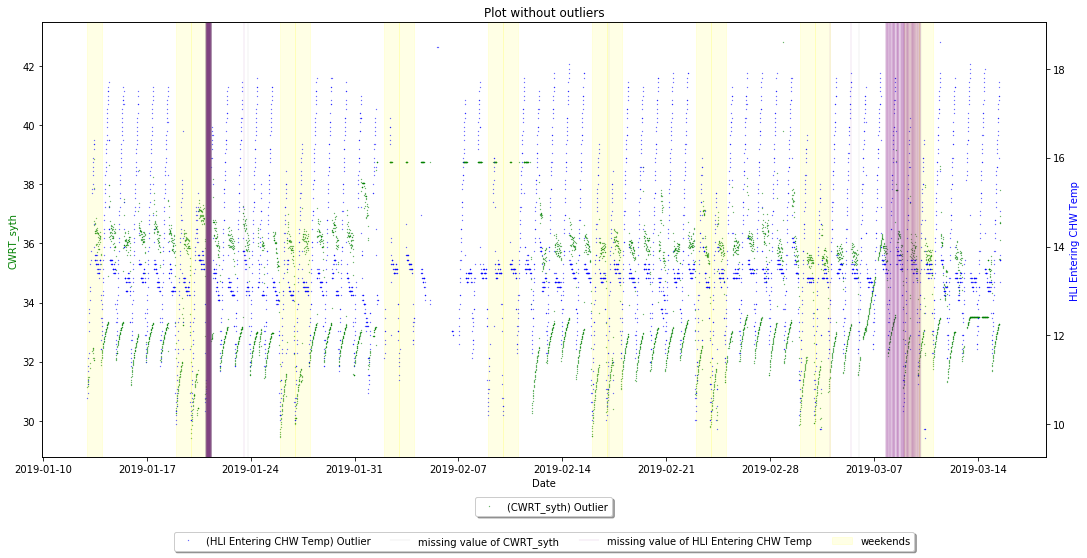

In [224]:
# ------------ plot data without outliers ------------------

fig, ax1 = plt.subplots(figsize=(18, 8))
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1))

for col, clr, ax_ in zip(maincols, ['green', 'blue'], [ax1, ax2]):
    # outliers 
    cond=1
    for cx in ['Final_OutlierScore_('+col+')', 'Final_OutlierScore_(AllColumns)']:
        cond = cond & (data_final[cx]<=score_cutoff[cx])
    sub1 = data_final[cond].copy()
    
    ax_.plot_date(sub1.index, sub1[col], c=clr, markersize=0.5, marker='.',
                  linestyle='', label='('+col+') Outlier')
    ax_.set_ylabel(col, color=clr)
    ax_.set_xlabel('Date')

tmp = data_final.index.to_frame()
tmp['wkday'] = data_final.index.weekday+1
tmp['date'] = tmp.index.date
allwknddate = np.unique(tmp.loc[tmp['wkday'].isin([6,7]), 'date'])
i = 0
for dt in allwknddate:
    alltm_dt = tmp[str(dt)].index
    if i == len(allwknddate)-1:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow', label='weekends')
    else:
        plt.axvspan(min(alltm_dt), max(alltm_dt), alpha=0.1, color='yellow')
    i += 1


# missing value outliers
for col, clr in zip(maincols, ['grey', 'purple']):
    ts_missing = list(data_final[data_final['LABEL_('+col+')_(wrong_gap)']].index)
    i=0
    for dt in ts_missing:
        if i == len(ts_missing)-1:
            plt.axvline(dt, alpha=1, color=clr, linestyle='-', linewidth=0.1, label='missing value of '+col)
        else:
            plt.axvline(dt, alpha=1, linestyle='-', linewidth=0.1, color=clr)
        i += 1
             
plt.title('Plot without outliers')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),fancybox=True, shadow=True, ncol=5)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16),fancybox=True, shadow=True, ncol=5)
plt.show()

